In [1]:
pwd

'/home/sasha/effective-inference/notebooks'

In [2]:
import pandas as pd
import timeit
import matplotlib.pyplot as plt
import json
from scipy.stats import entropy
from collections import Counter
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns

In [4]:
import ast
import re

def extract_function_names_ast(code):
    tree = ast.parse(code)
    function_names = []

    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            function_names.append(node.name)

    return function_names


def extract_function_code_with_regex(code):
    pattern = re.compile(r'\bdef\s+([a-zA-Z_][a-zA-Z0-9_]*)\s*\((.*?)\)\s*:\s*(.*?)(?=def|$)', re.DOTALL)
    matches = pattern.findall(code)
    functions = {}

    for match in matches:
        function_name = match[0]
        function_args = match[1]
        function_body = match[2]
        functions[function_name] = f"def {function_name}({function_args}):\n    {function_body}"

    return functions




In [8]:
dataset = pd.read_csv('clean_naming/code_data.csv', index_col=0).reset_index()
dataset = dataset.drop(['level_0'], axis=1)
dataset.head(5)

,index,code,prompt,bad_prompt,bad_code,prompt_names_dict,numerical_prompt,numerical_code,prompt_numerical_dict,translit_prompt,translit_code,translit_names_dict
0,0,"def cellname(x, y):\n ""Translate a cell coo...","def str(val):\n """"""Convert float to string,...","def locale_aware_float_to_string(val):\n """"...","def generate_cell_name(x, y):\n ""Translate ...","{""str"": ""locale_aware_float_to_string"", ""colnu...","def 0(val):\n """"""Convert float to string, t...","def 2(x, y):\n ""Translate a cell coordinate...","{""str"": ""0"", ""colnum2name"": ""1""}","def stroka(val):\n """"""Convert float to stri...","def imya_yacheiki(x, y):\n ""Translate a cel...","{""str"": ""stroka"", ""colnum2name"": ""kolonka_v_im..."
1,1,"def test_basic():\n ""Basic non-gui self-tes...","def cellname(x, y):\n ""Translate a cell coo...","def generate_cell_name(x, y):\n ""Translate ...","def perform_basic_non_gui_self_test():\n ""B...","{""cellname"": ""generate_cell_name""}","def 0(x, y):\n ""Translate a cell coordinate...","def 1():\n ""Basic non-gui self-test.""\n ...","{""cellname"": ""0""}","def imya_yacheiki(x, y):\n ""Translate a cel...","def test_bazovyj():\n ""Basic non-gui self-t...","{""cellname"": ""imya_yacheiki""}"
2,2,"def display_menu(stdscr, menu_y):\n ""Displa...","def erase_menu(stdscr, menu_y):\n ""Clear th...","def erase_menu_clears_menu_space(stdscr, menu_...",def display_menu_commands_and_instructions(std...,"{""erase_menu"": ""erase_menu_clears_menu_space""}","def 0(stdscr, menu_y):\n ""Clear the space w...","def 1(stdscr, menu_y):\n ""Display the menu ...","{""erase_menu"": ""0""}","def stirat_menyu(stdscr, menu_y):\n ""Clear ...","def otobrazit_menyu(stdscr, menu_y):\n ""Dis...","{""erase_menu"": ""stirat_menyu""}"
3,3,"def merge_profile():\n """"""Reads sys.getdxp(...","def has_pairs(profile):\n """"""Returns True i...","def check_for_pairs(profile):\n """"""Returns ...",def merge_profile_into_module_cached_copy():\n...,"{""has_pairs"": ""check_for_pairs""}","def 0(profile):\n """"""Returns True if the Py...","def 1():\n """"""Reads sys.getdxp() and merges...","{""has_pairs"": ""0""}","def imeet_pary(profile):\n """"""Returns True ...","def obedinit_profil():\n """"""Reads sys.getdx...","{""has_pairs"": ""imeet_pary""}"
4,4,"def snapshot_profile():\n """"""Returns the cu...","def merge_profile():\n """"""Reads sys.getdxp(...",def merge_profile_into_module_cached_copy():\n...,"def get_cumulative_execution_profile():\n ""...","{""merge_profile"": ""merge_profile_into_module_c...","def 0():\n """"""Reads sys.getdxp() and merges...","def 1():\n """"""Returns the cumulative execut...","{""merge_profile"": ""0""}","def obedinit_profil():\n """"""Reads sys.getdx...","def snimok_profilya():\n """"""Returns the cum...","{""merge_profile"": ""obedinit_profil""}"


## Make the new func names dataset

In [192]:
func_data = pd.DataFrame({'func_name': [],'func_definition': [], 'prompt': [], 'code': [] })
for i in range(dataset.shape[0]):
  line = dataset.loc[i]
  rows = []
  for func_name, func in extract_function_code_with_regex(line['prompt']).items():
    if func_name in line['code']:
      rows.append({'func_name': func_name,'func_definition':func,  'prompt': line['prompt'], 'code': line['code'], 'count': line['code'].count(func_name)})

  func_data = pd.concat([func_data, pd.DataFrame(rows)], ignore_index=True)

lst = '''parsedate_tz -> _parsedate_tz
make_translate -> make_translate
neg -> neg
grid_values -> grid_values
assign -> assign
eliminate -> eliminate
shuffled -> shuffled
assign -> assign
random_puzzle -> random_puzzle
get_dot_atom_text -> parse_dot_atom_text
get_domain -> parse_domain
get_display_name -> parse_display_name
get_extended_attrtext -> parse_extended_attrtext
get_extended_attribute -> parse_extended_attribute
Value -> synchronized_value
parse_mime_parameters -> parse_mime_parameters_from_value
_qencode -> quopri_encode
_format_timetuple_and_zone -> format_timetuple_and_zone
_parsedate_tz -> parse_date_with_timezone
vals_sorted_by_key -> values_sorted_by_key
_unpack_uint32 -> unpack_uint32
_install_handlers -> install_handlers_from_config
_resolve -> resolve_dotted_name
_strip_spaces -> strip_spaces_from_list
release -> get_system_release
_get_ptext_to_endchars -> get_ptext_until_endchars
Comment -> create_comment_element
get_cfws -> parse_cfws_from_value
_create_carefully -> create_carefully_and_open
_format -> format_with_options
h -> quadratic_function
prepend_module_to_path -> prepend_module_to_sys_path
from_qvariant -> convert_qvariant_to_python
get_prog -> get_program_name
marker -> parse_marker
get_unpatched -> retrieve_unpatched_item
liberal_is_HDN -> is_host_domain_name
escape_path -> escape_invalid_path_characters
addsitedir -> add_site_directory
getsitepackages -> get_site_packages_directories
addsitedir -> add_site_directory
abspath -> get_absolute_path
_joinrealpath -> join_real_path
_read_output -> read_command_output
_get_system_version_tuple -> get_system_version_tuple
S_IFMT -> get_file_mode_type
decode_long -> decode_twos_complement_long
makepath -> normalize_and_absolute_path
_init_pathinfo -> initialize_path_info
addpackage -> process_site_packages_pth
_get_path -> get_site_packages_path
getuserbase -> get_user_base
getusersitepackages -> get_user_site_packages
p -> parse_default_parameter
getfileinfo -> get_file_info
read_stringnl_noescape -> read_string_no_escape_nl
read_uint1 -> read_uint_1_byte
read_int4 -> read_int_4_bytes
read_uint4 -> read_uint_4_bytes
read_stringnl -> read_string_nl
LParen -> create_left_paren_leaf
find_binding -> find_variable_binding_node
find_root -> find_top_level_namespace_node
_generate_pickle_name -> generate_pickle_filename
_newer -> is_file_a_newer_than_b
load_grammar -> load_grammar_tables
get_lineno -> get_line_number_in_text_widget
idle_formatwarning -> format_warning_idly
showerror -> show_error_message
get_spaces_firstword -> extract_whitespace_and_first_word
reformat_paragraph -> reformat_text_paragraph
_pack_uint32 -> convert_uint32_to_little_endian_bytes
_get_supported_file_loaders -> get_supported_file_loaders_list
open_binary -> open_binary_resource
_path_from_reader -> get_path_from_reader
getparser -> create_parser_and_unmarshaller
_get_head_types -> get_head_types_from_pattern
get_all_fix_names -> get_all_fix_names_in_package
Dot -> create_dot_leaf
ArgList -> create_argument_list_node
Attr -> create_attribute_node
Name -> create_name_leaf
RParen -> create_right_paren_leaf
enabled -> use_distutils_local
_load_sysconfig_schemes -> load_sysconfig_schemes
_pypy_hack -> pypy_name_for_platform
warn_distutils_present -> warn_distutils_module_present_but_use_setuptools
enabled -> distutils_selection_by_env_var
_show -> message_box_show_with_icon_type_and_options
_load_scheme -> load_scheme_by_name
cache -> simple_unbounded_cache
_zip_equal -> zip_equal_or_raise_error
_chunked_even_finite -> chunk_even_finite_iterable
str -> convert_float_to_string
colnum2name -> convert_column_number_to_name
cellname -> generate_cell_name
has_pairs -> check_for_pairs
enumerate -> list_all_alive_thread_objects
has_pairs -> check_for_pairs
enumerate -> list_all_alive_thread_objects
common_pairs -> find_most_common_opcode_pairs
snapshot_profile -> get_cumulative_execution_profile
html_highlight -> convert_classified_text_to_html
alltt_escape -> replace_backslash_and_braces_with_escaped_equivalents
gettempdirb -> get_tempdir_as_bytes
_infer_return_type -> infer_implied_return_type
gettempdir -> get_tempdir_as_string
_get_candidate_names -> get_candidate_names
mksalt -> generate_salt
iter_importers -> yield_finders_for_module
get_importer -> retrieve_finder_for_path_item
str -> convert_float_to_string
find_lines -> search_for_lines
_find_lines_from_code -> search_for_lines_from_code
_try_compile -> attempt_compile
_format_code_info -> generate_code_info_format
_get_code_object -> extract_code_object
_try_compile -> attempt_compile
_get_code_object -> extract_code_object
_get_code_object -> obtain_code_object
findlinestarts -> locate_line_starts
_try_compile -> attempt_compile
b64encode -> encode_base64
b64decode -> decode_base64
_bytes_from_decode_data -> extract_bytes_from_decode_data
_85encode -> encode_85
str -> convert_float_to_string
_readmodule -> process_module_read
lru_cache -> fancy_cache_decorator
__get_builtin_constructor -> fetch_builtin_constructor
_maybe_compile -> potentially_compile
fnmatchcase -> name_match_case
match -> try_match
print_list -> display_extracted_list
extract_tb -> harvest_traceback_entries
_parse_value_tb -> _dissect_error_traceback
format_exception -> mold_exception_as_text
_formatwarnmsg_impl -> _craft_warning_message
_showwarnmsg_impl -> _present_warning_message
_is_internal_frame -> _looks_like_internal_frame
call -> shout_command
getstatusoutput -> retrieve_command_status_and_output
getincrementalencoder -> fetch_incremental_encoder
getincrementaldecoder -> fetch_incremental_decoder
enumerate -> get_all_alive_threads
makedirs -> create_directory_recursive
_execvpe -> _execute_via_path_variable
_isclass -> _is_non_generic_class
getpager -> decide_paging_method
_escape_stdout -> _encode_stdout_with_escape
plain -> remove_bold_formatting
_get_revised_path -> _adjust_path_for_current_directory
pdatecache -> update_source_cache
prepare_class -> prepare_metaclass_and_namespace
resolve_bases -> resolve_mro_entries_dynamically
enumerate -> get_all_alive_threads
calculate_meta -> calculate_most_derived_metaclass
wraps -> apply_update_wrapper_to_wrapper
parse227 -> parse_pasv_response
current_thread -> get_current_thread
active_count -> get_number_of_active_threads
mac_ver_xml -> get_mac_version_xml_info
filter -> filter_names_by_pattern
follow_symlinks -> follow_symlinks_until_real_file
uname -> get_platform_information
uname -> get_platform_information
_sys_version -> parse_python_sys_version
add_callers -> combine_caller_lists
isleap -> is_leap_year
weekday -> get_weekday
_has_code_flag -> has_code_flag
isbuiltin -> is_builtin_function_or_method
ismethoddescriptor -> is_method_descriptor
istraceback -> is_traceback
isframe -> is_frame
ismodule -> is_module
getsourcefile -> get_source_file
walktree -> walk_tree
getargs -> get_arguments
getframeinfo -> get_frame_info
getouterframes -> get_outer_frames
getinnerframes -> get_inner_frames
isbuiltin -> is_builtin_function_or_method
_signature_is_builtin -> is_builtin_signature
_astuple_inner -> convert_object_to_tuple_recursively
_deduplicate -> remove_duplicates_preserve_order
_eval_type -> evaluate_type_with_forward_references
_strip_annotations -> remove_type_annotations_recursively
str -> convert_float_to_locale_aware_string
_is_leap -> check_if_year_is_leap
_is_leap -> check_if_year_is_leap
_days_before_year -> calculate_days_before_start_of_year
_days_before_month -> calculate_days_before_start_of_month
_days_in_month -> get_number_of_days_in_month
getcontext -> get_current_thread_context_or_create_new
str -> convert_float_to_locale_aware_string
abs -> calculate_absolute_value
str -> convert_float_to_locale_aware_string
wraps -> create_decorator_with_update_wrapper
_isfinite -> check_if_value_is_finite
T -> calculate_punycode_parameter
bisect_left -> find_index_to_insert_left_sorted
bisect_right -> find_index_to_insert_right_sorted
_sum -> calculate_high_precision_sum
_convert -> convert_value_to_numeric_type
enumerate -> get_list_of_currently_alive_threads
fmean -> calculate_arithmetic_mean_of_floats
variance -> calculate_sample_variance
pvariance -> calculate_population_variance
_asdict_inner -> convert_object_to_dict_recursively
_is_dataclass_instance -> check_if_object_is_dataclass_instance
_localize -> format_number_with_locale
delocalize -> parse_number_string_with_locale
_parse_localename -> parse_locale_code
_build_localename -> build_locale_code
__import__ -> import_module
_normalize_module -> normalize_module
script_from_examples -> generate_script_from_examples
fallback_getpass -> get_password_with_warning
_getattribute -> get_attribute_recursive
_open_terminal -> open_pty_master_and_get_terminal
slave_open -> open_pty_slave_and_acquire_terminal
wait -> wait_for_futures
repeat -> timeit_repeat
_parse_mac -> parse_mac_address
_is_universal -> is_universal_mac
_find_mac_near_keyword -> find_mac_address_near_keyword
_find_mac_under_heading -> find_mac_address_under_heading
_windll_getnode -> get_hardware_address_windows
_builtin_from_name -> load_builtin_module
_readmailcapfile -> read_mailcap_file
parsefield -> parse_mailcap_field
_run_code -> run_code_in_namespace
selective_len -> count_chars_below_max
selective_find -> find_next_occurrence
T  -> calculate_punycode_parameter
enumerate -> get_alive_threads
generate_generalized_integer -> generate_generalized_variable_length_integer
adapt -> calculate_punycode_bias
T -> calculate_punycode_parameter
decode_generalized_number -> decode_generalized_variable_length_integer
adapt -> calculate_punycode_bias
str -> format_float_locale_aware
filter -> filter_names
_find_exe_version -> get_executable_version
_get_xxmodule_path -> get_xxmodule_path
get_ld_header -> get_ld_header_from_process
get_ld_header_info -> get_ld_header_info_from_process
filter -> filter_names
get_one_match -> get_first_matching_group
get_legacy -> get_legacy_naming_scheme
get_version -> get_highest_versioned_member
get_ld_headers -> parse_ld_headers
get_member -> get_matching_archive_member
get_shared -> extract_shared_objects
_other_endian -> get_opposite_endian_type
dyld_image_suffix -> get_dyld_image_suffix
dyld_image_suffix_search -> add_dyld_image_suffix_semantics
get_logger -> get_multiprocessing_logger
_run_finalizers -> run_finalizers_with_minpriority
address_type -> get_address_type
_fixup_main_from_path -> fixup_main_module_from_path
_new_value -> _create_new_value
_new_value -> _create_new_value
RawValue -> create_shared_memory_object
synchronized -> create_synchronized_object
convert_to_error -> handle_conversion_to_error
all_methods -> get_all_method_names
MakeProxyType -> create_proxy_type
dispatch -> send_message_and_receive_response
urlparse -> parse_url
_splitport -> split_host_and_port
getproxies_environment -> get_environment_proxies
_coerce_args -> _coerce_and_create_args
urlunsplit -> unsplit_url
_coerce_args -> _coerce_and_create_args
requires_to_requires_dist -> get_version_specifier_for_requirement
pkginfo_unicode -> coax_unicode_from_pkginfo
_should_cache -> can_cache_built_requirement
input -> create_file_input_instance
call_subprocess -> execute_subprocess
_test_writable_dir_win -> is_writable_directory_on_windows
get_best_invocation_for_this_python -> get_current_python_invocation
glibc_version_string_confstr -> get_glibc_version_string_using_confstr
glibc_version_string_ctypes -> get_glibc_version_string_using_ctypes
split_leading_dir -> split_first_directory_from_path
et_prog -> retrieve_program_and_handle_special_cases
create_package_set_from_installed -> generate_set_of_installed_packages_with_dependency_details
_create_whitelist -> derive_whitelist_based_on_installed_and_provided_packages
_simulate_installation_of -> predict_installed_packages_after_simulation
check_package_set -> validate_consistency_of_package_set
_check_download_dir -> verify_download_directory_for_existing_file_with_correct_hash
make_setuptools_develop_args -> generate_setuptools_develop_arguments_with_options
call_subprocess -> execute_subprocess_and_handle_return_code
format_command_result -> prepare_command_result_for_logging
runner_with_spinner_message -> execute_runner_with_spinner_displaying_message
error -> log_error_message
_module_repr_from_spec -> get_module_repr_from_spec
spec_from_file_location -> create_module_spec_from_file_location
_init_module_attrs -> initialize_module_attributes
_new_module -> create_new_module_instance
_load_unlocked -> load_module_unlocked
_find_and_load_unlocked -> find_and_load_module_unlocked
_resolve_name -> resolve_relative_module_name
_find_and_load -> find_and_load_module
_path_stat -> stat_path
_path_is_mode_type -> check_path_mode_type
check_first_requirement_in_file -> validate_first_line_as_requirements_file
is_installable_dir -> identify_directory_as_installable_project
_clean_url_path -> sanitize_url_path
wrapper -> initialize_curses_and_call_function
_create_link_from_element -> convert_anchor_element_attributes_to_link
_determine_base_url -> identify_base_url_from_html_document
_find_name_version_sep -> locate_separator_index_based_on_canonical_name
get_close_matches -> retrieve_similar_matches_using_sequence_matcher
ascii_lower -> transform_ascii_to_lower_with_unicode_support
_iter_decode_generator -> generate_decoded_output_iterator_using_decoder
get_filetype_from_line -> determine_filetype_from_last_line
doctype_matches -> check_if_doctype_matches_regex
guess_decode -> attempt_decoding_with_guess
regex_opt_inner -> generate_inner_regex_for_string_list
_apply -> apply_configuration_to_distribution
find_filter_class -> search_for_filter_class_by_name
guess_decode -> attempt_decoding_with_guess
get_lexer_by_name -> retrieve_lexer_by_alias
get_filetype_from_buffer -> determine_filetype_from_buffer
find_formatter_class -> look_up_formatter_class_by_alias_returning_none_if_not_found
load_system -> load_build_system_from_source_directory_pyproject_toml
check_call -> run_command_wait_for_completion_raise_exception_if_nonzero_exit_code
_build_backend -> find_and_load_build_backend_add_in_tree_backend_directories
_find_already_built_wheel -> check_for_already_built_wheel_get_wheel_metadata_hook
_build_backend -> find_and_load_build_backend_add_in_tree_backend_directories
_find_already_built_wheel -> check_for_already_built_wheel_get_wheel_metadata_hook
_build_backend -> find_and_load_build_backend_add_in_tree_backend_directories
parse_marker -> parse_marker_string_returning_dictionary_with_expression
finder -> return_resource_finder_for_package_with_caching
cookiejar_from_dict -> create_cookie_jar_from_key_value_dict_with_overwrite_option
to_key_val_list -> convert_object_to_list_of_tuples_if_possible
merge_setting -> determine_appropriate_setting_for_request_and_session_with_dictionary_merging
unquote_header_value -> reverse_quote_header_value_based_on_browser_implementation
_parse_content_type_header -> parse_content_type_header_returning_content_type_and_parameters
get_encoding_from_headers -> extract_encodings_from_http_header_dictionary
dotted_netmask -> convert_mask_from_slash_xx_format_to_quad_dotted_format
get_environ_proxies -> return_environment_proxies_dictionary_with_bypass_logic
parse_url -> parse_url_into_namedtuple_with_rfc3986_compliance
urlunparse -> put_together_parsed_url_with_redundant_delimiters_handling
is_dataclass -> check_if_object_is_dataclass_or_instance
cleandoc -> clean_up_indentation_from_docstrings
cell_len -> get_number_of_cells_required_to_display_text
get_host -> deprecated_use_parse_url_instead_get_scheme_host_and_port
resolve_cert_reqs -> resolve_argument_to_numeric_constant_for_cert_reqs
resolve_ssl_version -> resolve_argument_to_numeric_constant_for_ssl_version
wait_for_socket -> choose_wait_for_socket_implementation_delayed
_encode_invalid_chars -> _percent_encode_uri_component_without_reapplying_on_existing_percent_encoding
wait_for_read -> wait_for_socket_to_become_readable
_to_unicode -> convert_object_to_unicode_for_python2
is_appengine -> check_if_running_on_appengine
_cfstr -> create_cfstring_from_python_binary_data
_cf_string_to_unicode -> convert_cfstring_to_unicode_string
interpret_distro_name -> generate_alternative_interpretations_of_source_distro_name
egg_info_for_url -> extract_egg_info_from_url
distros_for_location -> yield_egg_or_source_distributions_based_on_basename
_resolve_tar_file_or_dir -> resolve_links_and_extract_link_targets_as_normal_files
find_package_path -> resolve_package_path_with_package_dir
_get_mro -> get_sorted_mro_of_bases
isdir -> check_if_path_is_existing_directory
_msvc14_get_vc_env -> get_vc_environment_variables_for_msvc14
_get_option -> get_target_option
_attrgetter -> safe_attr_getter
glob_relative -> expand_globs_relative
is_python -> check_valid_python_script
_safe -> escape_wheel_component
str -> locale_aware_float_to_string
_list_from_layouttuple -> construct_list_from_ttk_layout_tuple
_splitdict -> format_dict_from_tcl_list_pairs
_format_optdict -> format_option_dict_to_tuple_for_tk_call
_convert_stringval -> convert_value_to_more_appropriate_python_object
_list_from_statespec -> construct_list_from_state_spec_tuple
_tclobj_to_py -> convert_tcl_object_to_python_object
__dict_replace -> replace_substrings_using_dictionary
_do_pulldom_parse -> perform_pulldom_parse_and_get_root_node
_read_headers -> read_headers_into_list_from_file_pointer
_str2time -> convert_string_to_time
isCocoaTk -> is_using_cocoa_tk
readSystemPreferences -> read_macos_system_preferences
isAquaTk -> is_using_native_osx_tk
_ensure_future -> ensure_future_internal
ensure_future -> ensure_future_wrap
_get_running_loop -> get_running_event_loop
get_event_loop_policy -> get_current_event_loop_policy
_convert_future_exc -> convert_future_exception
isfuture -> is_future_instance
_create_formatters -> create_log_formatters
_find_lines -> get_line_numbers_for_code_objects
samestat -> are_stat_buffers_equal
getlines -> get_lines_from_cache
updatecache -> update_cache_entry
_calculate_meta -> calculate_most_derived_metaclass
_mac_ver_xml -> get_mac_version_info_from_xml
_follow_symlinks -> resolve_symlinks
_signature_fromstr -> parse_signature_from_string
erase_menu -> erase_menu_clears_menu_space
merge_profile -> merge_profile_into_module_cached_copy
urlopen -> urlopen_open_url_with_data_and_timeout
_get_default_tempdir -> _calculate_default_temporary_directory
_gettempdir -> _private_accessor_for_tempfile_tempdir
disassemble -> disassemble_code_object
_get_instructions_bytes -> _iterate_over_instructions_in_bytecode_string
_disassemble_bytes -> _disassemble_code_bytes
_disassemble_recursive -> _recursive_disassembly_of_code_object
_unpack_opargs -> _unpack_opcode_arguments
_write_file_prefix -> _write_shebang_line
_input_type_check -> _check_input_type
_aix_tag -> _infer_abi_bitwidth_for_aix
_aix_bgt -> _get_aix_build_gnu_type
_siftdown -> _sift_down_heap
_siftup -> _sift_up_heap
_siftup_max -> _sift_up_max_heap
_siftdown_max -> _sift_down_max_heap
function -> function_with_default_argument_Foo
_compose_mro -> _calculate_method_resolution_order
walk_tb -> walk_traceback_frames_and_line_numbers
walk_stack -> walk_stack_frames_and_line_numbers
removedirs -> remove_directory_and_empty_intermediate_dirs
execvp -> execute_executable_with_argument_list
execvpe -> execute_executable_with_argument_list_and_environment
pager -> determine_and_use_appropriate_pager
writedoc -> write_html_documentation_to_file
clearcache -> clear_entire_cache
_strptime -> _parse_time_from_string_with_format
__methodDict -> helper_function_for_scrolled_canvas
isclass -> check_if_object_is_class
isfunction -> determine_if_object_is_user_function
ismethod -> verify_if_object_is_instance_method
iscode -> check_if_object_is_code_object
getfile -> identify_source_or_compiled_file_of_object
isgenerator -> validate_if_object_is_generator
_genops -> generate_operations_from_data
_trace -> log_trace_message_if_verbose
token_bytes -> generate_random_byte_string_of_length
_find_executable -> search_for_executable_in_path_directories
_get_system_version -> retrieve_os_x_system_version_as_string
_save_modified_value -> persist_modified_and_original_values_of_configuration_variable
_sync_flush -> ensure_changes_to_file_are_physically_on_disk
getdefaultlocale -> attempt_to_determine_default_locale
debug_script -> debug_test_script
close -> close_the_sequence
_writen -> write_all_data_to_descriptor
no_type_check -> indicate_that_annotations_are_not_type_hints
_get_command_stdout -> obtain_stdout_of_command_with_args
_validate_tzfile_path -> validate_timezone_file_path
dyld_default_search -> search_for_library_using_dyld_default_semantics
dyld_executable_path_search -> search_for_library_using_executable_path
dyld_override_search -> override_search_for_library_using_dyld_semantics
dyld_find -> find_library_using_dyld_semantics
skip -> unconditionally_skip_test_due_to_reason
seal -> disable_automatic_generation_of_child_mocks
install_translator -> install_qt_translator_to_qapplication
convert_requirements -> generate_requires_dist_strings_for_parsed_requirements
_check_no_input -> check_for_no_input_and_raise_error
join_lines -> join_lines_ending_with_backslash_except_after_comments
expand_env_variables -> expand_environment_variables_in_lines_enum
raise_for_status -> check_and_raise_for_status
_ensure_html_header -> validate_and_ensure_html_header
_iter_encode_generator -> iterate_and_encode_generator
find_plugin_filters -> discover_and_return_plugin_filters
find_plugin_lexers -> search_and_retrieve_plugin_lexers
_load_lexers -> load_and_cache_lexers
find_lexer_class_for_filename -> search_and_get_lexer_class_for_filename
_iter_lexerclasses -> iterate_over_lexer_classes
_load_formatters -> load_and_cache_formatters
find_plugin_formatters -> discover_and_return_plugin_formatters
find_plugin_styles -> discover_and_return_plugin_styles
_get_wheel_metadata_from_wheel -> extract_metadata_from_wheel
make_graph -> generate_dependency_graph
create_cookie -> generate_cookie
request -> construct_and_send_request
should_bypass_proxies -> check_should_bypass_proxies
default_user_agent -> get_default_user_agent
inspect -> inspect_python_object
_replace_multiple -> replace_multiple_occurrences
create_urllib3_context -> generate_urllib3_context
_validate_dependencies_met -> validate_pyopenssl_dependencies
find_library -> search_library_on_aix
yield_lines -> generate_non_empty_lines
_unpack_zipfile_obj -> extract_from_zipfile_object
_iter_open_tar -> iterate_and_open_tar
_clear_modules -> clear_modules_list
_augment_exception -> add_details_to_exception
assert_string_list -> verify_string_list
cleanup -> perform_cleanup_operations
disable_stdlib_finder -> disable_stdlib_finder_by_monkey_patching
validator -> validate_wsgi_compliance
reduce -> cumulative_reduction
sorted_walk -> reproducible_os_walk
iter_symbols -> yield_code_symbols
_chunked_even_online -> yield_chunked_even_online
ensure_local_distutils -> ensure_local_distutils_with_import
_get_default_root -> get_default_root_or_support
is_HDN -> is_host_domain_name
deepvalues -> iterate_over_nested_mapping_sorted
_bootstrap -> bootstrap_pip_into_python
_get_module_lock -> get_or_create_module_lock
_wrap -> simple_substitute_for_update_wrapper
_lock_unlock_module -> acquire_and_release_module_lock
_sanity_check -> verify_sane_arguments
_set_bootstrap_module -> set_bootstrap_module
rec_test -> recursive_test_on_sequence
attr_chain -> follow_attribute_chain
generate_matches -> generate_matches_for_patterns
has_metaclass -> check_class_metaclass
tokenize_loop -> loop_over_tokens
fix_scaling -> scale_fonts_on_hidpi_displays
architecture -> query_executable_architecture
_init_tk_type -> initialize_osx_tk_variant_values
fixb2context -> remove_bad_aquatk_bindings
addOpenEventSupport -> add_open_event_support
overrideRootMenu -> replace_root_menu_for_idle
hideTkConsole -> try_hide_tk_console
close_subprocess_debugger -> close_debugger_subprocess
_set_task_name -> set_task_name_if_not_none
_init_event_loop_policy -> _initialize_event_loop_policy_with_default
_chain_future -> _chain_two_futures_and_copy_result
_format_callbacks -> _format_future_callbacks
_clearExistingHandlers -> _clear_and_close_existing_logging_handlers
_install_loggers -> _create_and_install_logging_loggers
_acquireLock -> _acquire_module_level_lock_for_serializing_access
_releaseLock -> _release_module_level_lock_acquired_by_acquireLock
basicConfig -> do_basic_configuration_for_logging_system
critical -> log_critical_message_on_root_logger
error -> log_error_message_on_root_logger
_validate_xtext -> _validate_xtext_and_register_defect_if_non_printables
get_comment -> parse_and_get_comment_from_value
get_fws -> parse_and_get_folding_whitespace_from_value
get_qp_ctext -> parse_and_get_quoted_printable_ctext_from_value
get_bare_quoted_string -> parse_and_get_bare_quoted_string_from_value
get_encoded_word -> parse_and_get_encoded_word_from_value
get_atext -> parse_and_get_atext_from_value
get_local_part -> parse_and_get_local_part_from_value
get_phrase -> parse_and_get_phrase_from_value
get_angle_addr -> parse_and_get_angle_addr_from_value
get_dtext -> parse_and_get_dtext_from_value
get_msg_id -> parse_and_get_message_id_from_value
get_unstructured -> parse_and_get_unstructured_from_value
get_ttext -> parse_and_get_ttext_from_value
get_attrtext -> parse_and_get_attrtext_from_value
get_quoted_string -> parse_and_get_quoted_string_from_value
_init_event_loop_policy -> initialize_global_event_loop_policy
_chain_future -> chain_two_futures
_format_callbacks -> format_callbacks_helper
_clearExistingHandlers -> clear_and_close_existing_handlers
_install_loggers -> configure_and_install_loggers
_acquireLock -> acquire_module_level_lock
_releaseLock -> release_module_level_lock
basicConfig -> do_basic_logging_configuration
critical -> log_critical_message_root_logger
error -> log_error_message_root_logger
_validate_xtext -> validate_xtext_input_token
get_comment -> parse_comment_from_value
get_fws -> parse_fws_from_value
get_qp_ctext -> parse_qp_ctext_from_value
get_bare_quoted_string -> parse_bare_quoted_string
get_encoded_word -> parse_encoded_word_from_value
get_atext -> parse_atext_from_value
get_local_part -> parse_local_part_from_value
get_phrase -> parse_phrase_from_value
get_angle_addr -> parse_angle_addr_from_value
get_dtext -> parse_dtext_from_value
get_msg_id -> parse_msg_id_from_value
get_unstructured -> parse_unstructured_value
get_ttext -> parse_ttext_from_value
get_attrtext -> parse_attrtext_from_value
get_quoted_string -> parse_quoted_string_from_value
test_basic -> perform_basic_non_gui_self_test
display_menu -> display_menu_commands_and_instructions
common_instructions -> get_most_common_opcodes
render_common_pairs -> render_most_common_opcode_pairs
seq -> generate_sequence_of_opcode_pairs
build_html_page -> create_html_page_with_colorized_code
latex_highlight -> create_latex_document_with_colorized_code
get_json -> download_and_decode_json_from_url
_sanitize_params -> sanitize_and_infer_params_for_api
_mkstemp_inner -> create_temporary_file_and_return_fd
crypt -> return_one_way_hash_with_salt
iter_modules -> iterate_over_modules_on_path
_split_optional_netmask -> split_netmask_and_raise_error_if_needed
distb -> disassemble_traceback
code_info -> format_details_of_methods_or_functions
get_instructions -> iterate_over_opcodes_in_code
_disassemble_str -> compile_and_disassemble_source_string
findlabels -> detect_offsets_of_jump_targets
_copy_archive -> copy_application_archive_with_shebang_modification
standard_b64encode -> encode_bytes_using_standard_base64_alphabet
standard_b64decode -> decode_bytes_with_standard_base64_alphabet
urlsafe_b64encode -> encode_bytes_using_urlsafe_base64
urlsafe_b64decode -> decode_bytes_using_urlsafe_base64
b16decode -> decode_bytes_with_base16
b85encode -> encode_bytes_in_base85_format
encodebytes -> encode_bytestring_into_base64_data
decodebytes -> decode_base64_data_into_bytestring
_aix_bosmp64 -> get_version_and_build_date_of_aix_bosmp64
aix_buildtag -> return_platform_tag_of_system_built_on
readmodule -> return_classes_in_module
execlpe -> execute_and_replace_current_process_environment
isdata -> check_if_object_represents_data
sort_attributes -> sort_attrs_in_place_by_fields_and_alphabetically
plainpager -> simply_print_unformatted_text_ultimate_fallback
describe -> produce_short_description_of_given_thing
writedocs -> write_html_documentation_for_all_modules
_adjust_cli_sys_path -> ensure_current_dir_on_sys_path_and_exclude_main
_keep_alive -> keep_reference_to_object_in_memo
commonprefix -> find_longest_common_leading_component
samefile -> test_whether_pathnames_reference_same_file_or_directory
sameopenfile -> test_whether_open_file_objects_reference_same_file
getline -> get_line_for_python_source_file_from_cache
new_class -> create_class_object_dynamically_using_appropriate_metaclass
raise_conversion_error -> wrap_any_raised_struct_errors_in_conversion_error
result -> handle_result_with_conversion_error
_strptime_time -> return_time_struct_based_on_input_string_and_format
_strptime_datetime -> return_datetime_instance_based_on_input_string_and_format
ftpcp -> copy_file_from_one_ftp_instance_to_another
currentThread -> return_current_thread_object_corresponding_to_callers_thread
activeCount -> return_number_of_thread_objects_currently_alive
__methods -> helper_function_for_scrolled_canvas
mac_ver -> get_macos_version_information_as_tuple
_platform -> helper_to_format_platform_string_in_filename_compatible_format
_syscmd_file -> interface_to_systems_file_command
system -> returns_the_system_or_os_name
node -> returns_the_computers_network_name
machine -> returns_the_machine_type
processor -> returns_the_true_processor_name
python_implementation -> returns_string_identifying_python_implementation
python_version -> returns_python_version_as_string
readmodule_ex -> retrieve_module_functions_and_classes_without_importing
insort_right -> insert_item_to_right_in_sorted_list_maintaining_order
insort_left -> insert_item_to_left_in_sorted_list_maintaining_order
heappush -> add_item_to_heap_maintaining_heap_invariant
heappop -> remove_and_return_smallest_item_from_heap_maintaining_invariant
heapreplace -> pop_and_return_smallest_then_add_new_item_to_heap
heappushpop -> fast_version_of_push_followed_by_pop_from_heap
heapify -> transform_list_into_heap_in_place
_heappop_max -> max_heap_version_of_pop_from_heap
_heapreplace_max -> max_heap_version_of_pop_followed_by_push_to_heap
_heapify_max -> transform_list_into_max_heap_in_place
_find_impl -> find_best_matching_implementation_from_registry_for_type
__py_new -> create_new_hashing_object_with_named_algorithm
__hash_new -> create_new_hashing_object_with_named_algorithm
compile_command -> compile_command_and_determine_if_incomplete
fnmatch -> test_whether_filename_matches_pattern
print_tb -> print_stack_trace_entries_up_to_limit
format_tb -> format_stack_trace_entries_up_to_limit
format_exc -> format_exception_as_string_up_to_limit
extract_stack -> extract_stack_with_limit_replacement_for_asyncio
formatwarning -> format_warning_the_standard_way
_showwarnmsg -> hook_to_write_warning_to_file_replace_if_needed
_formatwarnmsg -> function_to_format_warning_the_standard_way
_next_external_frame -> find_next_frame_not_involving_cpython_internals
getoutput -> return_output_of_executing_command_in_shell
iterencode -> encoding_iterator_using_incremental_encoder
iterdecode -> decoding_iterator_using_incremental_decoder
indexOf -> return_first_index_of_item_in_sequence
renames -> rename_old_to_new_across_devices_handling_directories
execlp -> execute_executable_file_along_path_replacing_current_process
python_version_tuple -> retrieve_python_version_as_tuple_of_strings_with_patchlevel
python_branch -> retrieve_python_implementation_branch_string
python_revision -> retrieve_python_implementation_revision_string
python_build -> retrieve_python_build_number_and_date_as_strings
python_compiler -> retrieve_compiler_used_for_compiling_python
add_func_stats -> combine_stats_for_two_profile_entries_with_callers
monthrange -> return_weekday_and_number_of_days_for_year_and_month
isdatadescriptor -> check_if_object_is_data_descriptor_return_true_or_false
isgeneratorfunction -> return_true_if_object_is_user_defined_generator_function
isasyncgenfunction -> return_true_if_object_is_asynchronous_generator_function
isroutine -> return_true_if_object_is_any_kind_of_function_or_method
getabsfile -> return_absolute_path_to_source_or_compiled_file_for_object
getclasstree -> arrange_list_of_classes_into_nested_hierarchy_of_lists
getargvalues -> get_information_about_arguments_passed_into_frame
stack -> return_list_of_records_for_stack_above_callers_frame
trace -> return_list_of_records_for_stack_below_current_exception
getgeneratorlocals -> get_mapping_of_generator_local_variables_to_values
_signature_is_functionlike -> test_if_object_is_duck_type_of_function_type
_signature_from_builtin -> get_signature_for_builtin_callables
binhex -> create_binhex_encoded_copy_of_file
read_stringnl_noescape_pair -> read_stringnl_noescape_and_return_pair
read_string1 -> read_string1_with_bytes_input
read_string4 -> read_string4_with_bytes_input
read_bytes1 -> read_bytes1_with_bytes_input
read_bytes4 -> read_bytes4_with_bytes_input
read_unicodestringnl -> read_unicodestringnl_with_bytes_input
read_unicodestring1 -> read_unicodestring1_with_bytes_input
read_decimalnl_short -> read_decimalnl_short_with_bytes_input
read_decimalnl_long -> read_decimalnl_long_with_bytes_input
read_floatnl -> read_floatnl_with_bytes_input
read_long1 -> read_long1_and_return_decoded_value_from_bytes_input
read_long4 -> read_long4_and_return_decoded_value_from_bytes_input
genops -> generate_all_opcodes_in_pickle_and_return_opcode_info
removeduppaths -> remove_duplicate_entries_from_sys_path_and_make_absolute
addusersitepackages -> add_per_user_site_package_to_sys_path
addsitepackages -> add_site_packages_to_sys_path
recursive_repr -> decorator_to_make_repr_return_fillvalue_for_recursive_call
decorating_function -> function_decorated_to_handle_recursive_repr
token_hex -> return_random_text_string_in_hexadecimal_with_nbytes
token_urlsafe -> return_random_URL_safe_text_string_in_Base64_encoding_with_nbytes
realpath -> return_canonical_path_of_specified_filename_eliminating_symbolic_links
_find_build_tool -> find_build_tool_on_current_path_or_using_xcrun
_default_sysroot -> return_the_root_of_the_default_sysroot_for_compiler
_supports_universal_builds -> return_true_if_universal_builds_are_supported_on_this_system
_supports_arm64_builds -> return_true_if_arm64_builds_are_supported_on_this_system
_remove_universal_flags -> remove_all_universal_build_arguments_from_config_vars
_override_all_archs -> allow_override_of_all_archs_with_ARCHFLAGS_env_var
S_ISDIR -> return_true_if_mode_is_from_a_directory
S_ISCHR -> return_true_if_mode_is_from_a_character_special_device_file
S_ISBLK -> return_true_if_mode_is_from_a_block_special_device_file
S_ISREG -> return_true_if_mode_is_from_a_regular_file
S_ISFIFO -> return_true_if_mode_is_from_a_FIFO_named_pipe
S_ISLNK -> return_true_if_mode_is_from_a_symbolic_link
S_ISSOCK -> return_true_if_mode_is_from_a_socket
Int2AP -> convert_integer_to_A_P_string_representation
_create_temporary -> create_a_temp_file_based_on_path_and_open_for_reading_and_writing
_sync_close -> close_file_ensuring_all_changes_are_physically_on_disk
localize -> parse_string_as_locale_number_according_to_locale_settings
atof -> parse_string_as_float_according_to_locale_settings
atoi -> convert_string_to_integer_according_to_locale_settings
getlocale -> getlocale_and_return_current_setting_for_given_locale_category_as_tuple
resetlocale -> resetlocale_and_set_locale_for_category_to_default_value
testsource -> extract_test_sources_from_doctest_docstring_as_script
debug_src -> debug_src_and_debug_single_doctest_docstring_in_argument_src
win_getpass -> win_getpass_and_prompt_for_password_with_echo_off
whichmodule -> whichmodule_and_find_module_an_object_belongs_to
openpty -> openpty_and_open_a_pty_master_slave_pair_using_os_openpty_if_possible
master_open -> master_open_and_open_a_pty_master_return_fd_and_filename_of_slave_end
_copy -> _copy_and_parent_copy_loop_copies_pty_master_standard_output_standard_input
spawn -> spawn_and_run_another_program_in_a_new_process_specified_as_command_list_cmd
contextmanager -> contextmanager_decorator_typical_usage
some_generator -> some_generator_with_setup_yield_value_and_finally_cleanup
helper -> helper_and_return_generator_context_manager_instance
asynccontextmanager -> asynccontextmanager_decorator_typical_usage
some_async_generator -> some_async_generator_with_setup_yield_value_and_finally_cleanup
_exact_ratio -> _exact_ratio_and_return_real_number_x_to_exact_numerator_denominator_pair
_find_lteq -> _find_lteq_and_locate_leftmost_value_exactly_equal_to_x
_find_rteq -> _find_rteq_and_locate_rightmost_value_exactly_equal_to_x
mean -> mean_and_return_sample_arithmetic_mean_of_data
count -> count_and_return_the_number_of_elements_in_data
geometric_mean -> geometric_mean_and_return_geometric_mean_of_data
stdev -> stdev_and_return_square_root_of_sample_variance
pstdev -> pstdev_and_return_square_root_of_population_variance
asdict -> asdict_and_return_fields_of_dataclass_instance_as_dictionary
astuple -> astuple_and_return_fields_of_dataclass_instance_as_tuple
_remove_dups_flatten -> _remove_dups_flatten_and_internal_helper_for_Union_creation_and_substitution
no_type_check_decorator -> no_type_check_decorator_and_decorator_to_give_another_decorator_the_no_type_check_effect
wrapped_decorator -> wrapped_decorator_and_wrap_the_decorator_with_something_that_wraps_the_decorated_function_in_no_type_check
DER_cert_to_PEM_cert -> DER_cert_to_PEM_cert_and_take_certificate_in_binary_DER_format_and_return_PEM_version_as_string
_ymd2ord -> _ymd2ord_and_convert_year_month_day_to_ordinal_considering_01_Jan_0001_as_day_1
localcontext -> extended_context_manager_returns_context_manager
sin -> calculate_sine_with_extended_context
_normalize -> adjust_operands_and_return_normalized
_decimal_lshift_exact -> compute_integer_after_left_shift
_log10_lb -> lower_bound_for_log_base_10_of_positive_integer
_group_lengths -> convert_localeconv_grouping_to_iterable
_ifconfig_getnode -> get_hardware_address_using_ifconfig
_ip_getnode -> get_hardware_address_using_ip
_arp_getnode -> get_hardware_address_using_arp
_lanscan_getnode -> get_hardware_address_using_lanscan
_netstat_getnode -> get_hardware_address_using_netstat
_ipconfig_getnode -> deprecated_get_hardware_address_on_windows
_netbios_getnode -> deprecated_get_hardware_address_on_windows
init_builtin -> deprecated_load_and_return_builtin_module
readmailcapfile -> deprecated_read_mailcapfile_use_getcaps
parseline -> parse_one_entry_in_mailcap_file_return_dictionary
_run_module_code -> helper_to_run_code_in_new_namespace
insertion_unsort -> insertion_unsort_coding_with_oldchar
generate_integers -> bias_adaptation_generate_integers
insertion_sort -> insertion_unsort_coding_with_char
normalize_encoding -> normalize_encoding_name_ascii_only
_find_all_simple -> find_all_files_under_path
get_versions -> try_to_find_versions_of_gcc_ld_dllwrap
copy_xxmodule_c -> helper_for_tests_copying_xxmodule_c
test_compile -> test_compile_copying_xxmodule_c
find_tzfile -> retrieve_path_to_tzif_file_from_key
get_libpaths -> on_aix_buildtime_searchpath_stored_in_executable
find_shared -> search_directories_for_archive_and_return_result
_inject -> inject_paths_with_suffix
framework_find -> find_framework_using_dyld_semantics_loose_manner
doModuleCleanups -> execute_all_module_cleanup_functions_normally_called_for_you_after_tear_down_module
skipIf -> skip_test_if_condition_is_true
skipUnless -> skip_test_unless_condition_is_true
log_to_stderr -> turn_on_logging_and_add_stderr_handler
_cleanup_tests -> cleanup_multiprocessing_resources_when_tests_completed
SocketClient -> return_connection_object_connected_to_socket_given_by_address
import_main_path -> set_sys_modules___main___to_module_at_main_path
RawArray -> return_ctypes_array_allocated_from_shared_memory
public_methods -> return_list_of_names_of_methods_of_obj_which_do_not_start_with_underscore
AutoProxy -> return_an_auto_proxy_for_token
request_host -> return_request_host_as
build_opener -> create_an_opener_object_from_list_of_handlers
proxy_bypass_environment -> test_if_proxies_should_not_be_used_for_particular_host
urldefrag -> remove_any_existing_fragment_from_url
to_text_string -> convert_obj_to_unicode_text_string
to_binary_string -> convert_obj_to_binary_string
qbytearray_to_str -> convert_qbytearray_object_to_str_compatible_with_python_2_3
get_module_path -> return_module_modname_base_path
get_changeset -> return_mercurial_repository_path_revision_number
prepend_modules_to_path -> prepend_to_sys_path_all_modules_located_in_module_base_path
qapplication -> return_qapplication_instance
keybinding -> return_keybinding
onerror -> error_handler_for_shutil_rmtree
generate_requirements -> convert_requirements_from_setup_style_dictionary
dedent_description -> dedent_and_convert_pkg_info_description_to_unicode
_get_cache_dir -> return_persistent_or_temporary_cache_directory
backup_dir -> figure_out_name_of_directory_to_back_up_given_dir_to
egg_link_path_from_sys_path -> look_for_egg_link_file_for_project_name_by_walking_sys_path
test_writable_dir -> check_if_directory_is_writable
get_best_invocation_for_this_pip -> try_to_figure_out_best_way_to_invoke_pip_in_current_environment
guess_lexer -> determine_lexer_by_text_with_options_and_handle_exceptions
get_all_formatters -> retrieve_all_formatter_classes_and_handle_cache
get_formatter_by_name -> lookup_and_instantiate_formatter_by_alias_with_exception
get_all_styles -> generate_generator_for_all_styles_both_builtin_and_plugin
compat_system -> attempt_to_get_build_system_backend_and_requirements
default_subprocess_runner -> execute_subprocess_with_default_settings
_supported_features -> list_supported_options_features_supported_by_backend
get_requires_for_build_wheel -> invoke_optional_hook_get_requires_for_build_wheel
get_requires_for_build_editable -> invoke_optional_hook_get_requires_for_build_editable
prepare_metadata_for_build_wheel -> invoke_optional_hook_prepare_metadata_for_build_wheel
prepare_metadata_for_build_editable -> invoke_optional_hook_prepare_metadata_for_build_editable
build_wheel -> invoke_mandatory_hook_build_wheel_with_copy_if_prebuilt
build_editable -> invoke_optional_hook_build_editable_with_copy_if_prebuilt
get_requires_for_build_sdist -> invoke_optional_hook_get_requires_for_build_sdist
build_sdist -> invoke_mandatory_hook_build_sdist
get_dependent_dists -> generate_list_of_dependent_distributions_recursive
get_required_dists -> generate_list_of_required_distributions_recursive
interpret -> evaluate_marker_and_return_result_with_context_handling
finder_for_path -> return_resource_finder_for_path_with_cache_handling
intranges_from_list -> represent_list_of_integers_as_sequence_of_ranges
intranges_contain -> determine_if_integer_falls_into_one_of_ranges
merge_cookies -> add_cookies_to_cookiejar_and_return_merged_cookiejar
merge_hooks -> properly_merge_request_and_session_hooks_with_handling
options -> send_options_request_with_optional_arguments_handling
head -> send_head_request_with_optional_arguments_handling
post -> send_post_request_with_data_and_json_handling
put -> send_put_request_with_data_handling
patch -> send_patch_request_with_data_handling
delete -> send_delete_request_with_optional_arguments_handling
parse_list_header -> parse_lists_as_described_by_rfc_with_quoted_string_handling
virtualenv_no_global -> check_if_running_under_venv_and_return_no_global_flag
warn_if_run_as_root -> issue_warning_for_sudo_users_on_unix
_get_prepared_distribution -> prepare_distribution_for_install_requirement_with_tracker
install_editable -> run_setup_py_develop_for_package_in_editable_mode
get_legacy_build_wheel_path -> return_path_to_legacy_wheel_in_temp_dir
generate_editable_metadata -> generate_metadata_for_build_editable_using_pep660
build_wheel_editable -> build_wheel_for_install_requirement_using_pep660
build_wheel_pep517 -> build_wheel_for_install_requirement_using_pep517
deduce_helpful_msg -> return_helpful_message_for_requirements_file
find_path_to_project_root_from_repo_root -> find_project_root_relative_to_repo_root
_infer_user -> try_to_find_user_scheme_for_current_platform
_parse_links_html5lib -> parse_html_document_and_yield_anchor_elements
transform_hits -> convert_list_of_versions_into_list_of_packages
_import_module -> import_module_and_return_last_module
lookup -> look_for_encoding_by_label
iter_decode -> pull_based_decoder_for_unicode_strings
iter_encode -> pull_based_encoder_for_unicode_strings
html_doctype_matches -> check_if_file_has_html_doctype
guess_decode_from_terminal -> decode_text_based_on_terminal_encoding
bygroups -> callback_that_yields_actions_for_each_group_in_match
callback -> callback_that_processes_matched_groups
regex_opt -> compiled_regex_matching_strings_in_list
apply_filters -> apply_filters_to_stream_using_given_filters
get_filter_by_name -> return_instantiated_filter_by_name
get_all_filters -> generate_all_filter_names
get_all_lexers -> generate_all_lexer_info_tuples
find_lexer_class -> lookup_lexer_class_by_name
find_lexer_class_by_name -> lookup_lexer_class_by_alias
get_lexer_for_filename -> get_lexer_for_filename_and_code
get_lexer_for_mimetype -> get_lexer_for_mimetype_and_options
add_dict_to_cookiejar -> add_dictionary_to_cookie_jar_with_given_cookies
get_unicode_from_response -> retrieve_unicode_content_from_response_object_and_handle_warnings
address_in_network -> check_if_ip_belongs_to_network_subnet_and_return_boolean
select_proxy -> choose_proxy_for_given_url_from_provided_proxy_dictionary
resolve_proxies -> resolve_proxies_based_on_request_and_configuration_input
default_headers -> generate_default_headers_as_case_insensitive_dictionary
prepend_scheme_if_needed -> prepend_given_scheme_to_url_if_not_present
urldefragauth -> remove_fragment_and_authentication_from_url
pick_unit_and_suffix -> choose_unit_and_suffix_for_given_size_and_suffix_list
reconfigure -> replace_global_console_with_another_console_instance
set_cell_size -> adjust_string_length_to_fit_within_given_number_of_cells
format_header_param_html5 -> format_and_quote_single_header_param_using_html5_strategy
connection_from_url -> create_connection_pool_instance_for_given_url
create_proxy_ssl_context -> generate_ssl_context_for_given_ssl_version_and_cert_requirements
wait_for_write -> wait_for_writing_to_be_available_on_given_socket
_const_compare_digest_backport -> compare_two_digests_of_equal_length_in_constant_time
_encode_target -> percent_encode_request_target_to_avoid_invalid_characters
is_connection_dropped -> check_if_connection_dropped_and_should_be_closed
_ipaddress_match -> perform_exact_matching_of_ip_addresses
is_appengine_sandbox -> report_if_app_running_in_first_generation_sandbox
inject_into_urllib3 -> monkey_patch_urllib3_with_pyopenssl_ssl_support
_create_cfstring_array -> create_cfmutablearray_from_list_of_python_binary_data
_assert_no_error -> check_return_code_and_throw_exception_on_error
load_cdll -> load_dynamic_link_library_by_name_with_fallback_path
safe_version -> convert_arbitrary_string_to_standard_version_string
parse_requirements -> yield_requirement_objects_for_each_specification_in_strings
split_sections -> split_string_or_iterable_into_section_content_pairs
distros_for_url -> yield_egg_or_source_distribution_objects_for_given_url
unpack_zipfile -> unpack_zip_file_to_given_extract_directory
unpack_tarfile -> unpack_tar_or_targz_or_tarbz2_file_to_given_extract_directory
find_parent_package -> find_parent_package_with_sorted_and_common_ancestors
strip_marker -> strip_marker_and_avoid_calling_pip_with_environment_marker
hide_setuptools -> remove_references_to_setuptools_modules_and_allow_appropriate_import
_have_cython -> check_if_cython_can_be_imported_and_return_true_or_false
get_unpatched_class -> protect_against_repatching_distutils_and_ensure_no_prior_patch
_msvc14_find_vc2015 -> find_vc2015_for_msvc14_and_return_best_version_and_directory
msvc14_get_vc_env -> patched_get_vc_env_for_msvc14_and_support_extra_compilers
msvc14_gen_lib_options -> patched_gen_lib_options_for_msvc14_and_fix_compatibility
load_group -> given_value_return_entry_point_as_entry_point
check_nsp -> verify_valid_namespace_packages_and_warn_if_not_declared
check_package_data -> verify_value_as_dict_of_package_names_to_glob_lists
unpack -> move_everything_under_source_directory_to_destination_directory
_pathlib_compat -> convert_path_like_objects_to_filename_for_compatibility
_special_method_cache -> install_wrapper_method_and_return_simple_proxy
proxy -> create_proxy_to_installed_wrapper_method_and_use_it
retry_call -> trap_specified_exceptions_for_up_to_specified_retries
install -> add_backport_distribution_finder_to_sys_meta_path
matches -> check_if_finder_module_is_frozen_importlib_external_and_has_find_distributions
consumer -> advance_reverse_iterator_to_first_yield_point_automatically
tally -> print_thing_number_and_state_using_reverse_iterator
repeat_last -> return_sequence_of_elements_and_then_return_none
filter_except -> yield_items_that_validator_does_not_raise_specified_exceptions_for
map_except -> transform_items_with_function_and_yield_result_except_specified_exceptions
nth_product -> compute_product_at_sort_position_index_without_computing_previous_products
pad_none -> return_sequence_of_elements_and_then_return_none
ncycles -> return_sequence_elements_n_times
repeatfunc -> call_function_repeatedly_and_return_iterable_over_results
first_true -> return_first_true_value_in_iterable
normalize_path -> normalize_path_by_ensuring_it_is_only_a_file_name
_some_attrgetter -> extended_attribute_getter_for_truthy_values
_acessor -> attribute_accessor_with_items
canonic_data_files -> canonicalize_data_files_for_setup_py
walk_egg -> egg_directory_contents_walker_without_metadata
is_python_script -> determine_if_text_is_entire_python_script
only_strs -> filter_only_string_values
run_commands -> execute_all_commands_in_distribution
scheme -> override_selected_posix_prefix_scheme
_load_schemes -> extend_and_load_schemes
_inject_headers -> resolve_and_inject_headers_for_scheme
repeat_each -> repeat_each_element_in_iterable
zip_equal -> zip_iterables_and_raise_error_on_unequal_lengths
chunked_even -> break_iterable_into_approximately_equal_length_lists
triplewise -> return_overlapping_triplets_from_iterable
do_override -> ensure_local_distutils_override
showinfo -> display_info_message_with_title
showwarning -> display_warning_message_with_title
askquestion -> prompt_user_with_question_and_title
askokcancel -> ask_if_operation_should_proceed_with_ok_cancel
askyesno -> ask_user_yes_or_no_question_with_title
askyesnocancel -> ask_user_yes_no_cancel_question_with_title
askretrycancel -> ask_if_operation_should_be_retried_with_retry
mainloop -> run_tcl_main_loop_with_iteration_limit
getboolean -> convert_tcl_object_to_boolean
_val_or_dict -> format_options_and_call_tk_command
tclobjs_to_py -> convert_tcl_objects_to_python
unescape -> unescape_string_with_entities_dictionary
parseString -> parse_string_into_dom_from_string
parse_headers -> parse_rfc2822_headers_from_file_pointer
iso2time -> parse_iso8601_time_from_text
iso2time -> parse_iso8601_time_from_text_and_return
user_domain_match -> check_blocking_accepting_domains_for_match
request_path -> get_path_component_of_request_uri_as_string
reach -> return_reach_of_host_as_string
bootstrap -> bootstrap_pip_into_python_installation
resolve_name -> resolve_relative_module_name_to_absolute
_requires_builtin -> verify_module_is_builtin_decorator
_requires_builtin_wrapper -> wrapper_to_verify_module_is_builtin
_requires_frozen -> verify_module_is_frozen_decorator
_requires_frozen_wrapper -> wrapper_to_verify_module_is_frozen
_module_repr -> implementation_of_module_type_repr
spec_from_loader -> create_module_spec_based_on_loader_methods
module_from_spec -> create_module_based_on_spec
_load -> return_new_module_loaded_by_loader
_gcd_import -> import_and_return_module_based_on_name
_path_isfile -> replacement_for_os_path_isfile
_path_isdir -> replacement_for_os_path_isdir
_write_atomic -> write_data_to_path_atomically
_calc_mode -> calculate_mode_permissions_for_bytecode
_validate_timestamp_pyc -> validate_timestamp_based_pyc_against_source
_code_to_timestamp_pyc -> produce_data_for_timestamp_based_pyc
_code_to_hash_pyc -> produce_data_for_hash_based_pyc
_install -> install_path_based_import_components
loads -> convert_xml_rpc_packet_to_unmarshalled_data
_get_headnode_dict -> return_dictionary_of_head_node_types
get_fixers_from_package -> return_fully_qualified_names_for_fixers
Call -> create_function_call_node
ImportAndCall -> return_import_statement_and_method_call_node
is_tuple -> check_if_node_represents_tuple_literal
in_special_context -> check_if_node_is_in_iterable_context
does_tree_import -> does_tree_import_checking_top_level
fixup_parse_tree -> fixup_parse_tree_ensure_suite_format
fixup_simple_stmt -> fixup_simple_stmt_semicolon_handling
load_packaged_grammar -> load_pickled_grammar_from_package_or_file
tokenize -> tokenize_with_readline_and_tokeneater
get_end_linenumber -> get_end_linenumber_of_text_widget
idle_showwarning -> show_warning_in_idle_format
idle_showwarning_subproc -> show_warning_in_idle_format_subprocess
show_socket_error -> show_socket_error_with_messagebox
get_line_info -> get_line_info_tuple_indent_codeline
build_bits -> build_bits_for_platform
reformat_comment -> reformat_comment_with_header_limit
isCarbonTk -> is_carbon_tk_used
isXQuartz -> is_xquartz_used
tkVersionWarning -> tk_version_warning_message
preferTabsPreferenceWarning -> prefer_tabs_preference_warning_message
setupApp -> setup_app_perform_customizations
wrap_info -> wrap_info_replace_traceback_id
close_remote_debugger -> close_remote_debugger_shutdown_link
format_selection -> format_selection_apply_format_line
apply -> apply_format_line_to_selected_lines
create_task -> create_task_schedule_coroutine
run_coroutine_threadsafe -> run_coroutine_threadsafe_submit_to_loop
get_running_loop -> get_running_loop_raise_runtime_error
set_event_loop -> set_event_loop_via_event_loop_policy
new_event_loop -> new_event_loop_via_event_loop_policy
get_child_watcher -> get_child_watcher_via_event_loop_policy
set_child_watcher -> set_child_watcher_via_event_loop_policy
_set_concurrent_future_state -> set_concurrent_future_state_from_future
_copy_future_state -> copy_future_state_from_another_future
does_tree_import -> does_tree_import_checking_top_level
fixup_parse_tree -> fixup_parse_tree_ensure_suite_format
fixup_simple_stmt -> fixup_simple_stmt_semicolon_handling
load_packaged_grammar -> load_pickled_grammar_from_package_or_file
tokenize -> tokenize_with_readline_and_tokeneater
get_end_linenumber -> get_end_linenumber_of_text_widget
idle_showwarning -> show_warning_in_idle_format
idle_showwarning_subproc -> show_warning_in_idle_format_subprocess
show_socket_error -> show_socket_error_with_messagebox
get_line_info -> get_line_info_tuple_indent_codeline
build_bits -> build_bits_for_platform
reformat_comment -> reformat_comment_with_header_limit
isCarbonTk -> is_carbon_tk_used
isXQuartz -> is_xquartz_used
tkVersionWarning -> tk_version_warning_message
preferTabsPreferenceWarning -> prefer_tabs_preference_warning_message
setupApp -> setup_app_perform_customizations
wrap_info -> wrap_info_replace_traceback_id
close_remote_debugger -> close_remote_debugger_shutdown_link
format_selection -> format_selection_apply_format_line
apply -> apply_format_line_to_selected_lines
create_task -> create_task_schedule_coroutine
run_coroutine_threadsafe -> run_coroutine_threadsafe_submit_to_loop
get_running_loop -> get_running_loop_raise_runtime_error
set_event_loop -> set_event_loop_via_event_loop_policy
new_event_loop -> new_event_loop_via_event_loop_policy
get_child_watcher -> get_child_watcher_via_event_loop_policy
set_child_watcher -> set_child_watcher_via_event_loop_policy
_set_concurrent_future_state -> set_concurrent_future_state_from_future
_copy_future_state -> copy_future_state_from_another_future
parsedate -> convert_time_string_to_time_tuple
header_encode -> encode_single_header_with_base64_in_given_charset
translate -> translate_symbolic_cnf_to_numbered_cnf_and_return_reverse_mapping
from_dnf -> convert_from_or_of_ands_to_and_of_ors_in_cnf
parse_grid -> convert_grid_to_dict_of_possible_values_or_return_false_if_contradiction_detected
configuration_to_dict -> return_dict_of_configuration_data_gathered_by_given_handlers
wrap_future -> wrap_given_concurrent_futures_Future_object
_future_repr_info -> helper_function_for_Future_repr_with_exception_information_and_callbacks
fileConfig -> read_logging_configuration_from_ConfigParser_format_file
addLevelName -> associate_levelName_with_level_for_message_formatting
_removeHandlerRef -> remove_handler_reference_from_internal_cleanup_list
_addHandlerRef -> add_handler_to_internal_cleanup_list_using_weak_reference
fatal -> don_t_use_this_function_use_critical_instead
exception -> log_message_with_severity_ERROR_on_root_logger_with_exception_information
warning -> log_message_with_severity_WARNING_on_root_logger
info -> log_message_with_severity_INFO_on_root_logger
debug -> log_message_with_severity_DEBUG_on_root_logger
log -> log_msg_with_integer_severity_level_on_root_logger
get_qcontent -> qcontent_equals_qtext_or_quoted_pair
get_atom -> atom_equals_optional_CFWS_one_or_more_atext_optional_CFWS
get_dot_atom -> dot_atom_equals_optional_CFWS_dot_atom_text_optional_CFWS
get_addr_spec -> addr_spec_equals_local_part_at_domain
get_name_addr -> name_addr_equals_optional_display_name_angle_addr
get_invalid_mailbox -> read_everything_up_to_one_of_the_chars_in_endchars_outside_formal_grammar
get_no_fold_literal -> no_fold_literal_equals_bracket_zero_or_more_dtext_bracket
parse_message_id -> message_id_equals_Message_ID_msg_id_CRLF
get_invalid_parameter -> read_everything_up_to_next_semicolon_outside_formal_grammar
get_token -> token_equals_optional_CFWS_one_ttext_optional_CFWS
get_attribute -> optional_CFWS_one_or_more_attrtext_optional_CFWS
get_value -> quoted_string_or_attribute
_find_mime_parameters -> do_our_best_to_find_parameters_in_invalid_MIME_header
encode_base64 -> encode_message_payload_in_Base64_and_add_Content_Transfer_Encoding_header
encode_quopri -> encode_message_payload_in_quoted_printable_and_add_Content_Transfer_Encoding_header
getaddresses -> return_list_of_REALNAME_EMAIL_for_each_fieldvalue
format_datetime -> turn_datetime_into_date_string_as_specified_in_RFC_2822'''
names_dict = {}
for [x, y] in list(map(lambda x: x.split(' -> '), lst.split('\n'))):
  names_dict[x] = y


func_data['bad_name'] = func_data['func_name'].apply(lambda x: names_dict[x] if x in names_dict.keys() else "")
func_data = func_data.drop_duplicates(subset = 'func_name')
# func_data.to_csv('functions_data.csv')

In [194]:
'str' in names_dict.keys()

True

In [13]:
func_data =func_data.drop_duplicates(subset = 'func_name')
list(func_data[func_data['bad_name']== ""]['func_definition'])[:30]

[]

In [54]:
dataset[dataset['code'].str.count('pager')>2]

,index,code,prompt,bad_prompt,bad_code,prompt_names_dict,numerical_prompt,numerical_code,prompt_numerical_dict
83,83,"def pager(text):\n """"""The first time this i...","def pager(text):\n """"""The first time this i...",def determine_and_use_appropriate_pager(text):...,def determine_and_use_appropriate_determine_an...,"{""pager"": ""determine_and_use_appropriate_pager...","def 0(text):\n """"""The first time this is ca...","def 0(text):\n """"""The first time this is ca...","{""pager"": ""0"", ""getpager"": ""1""}"


In [263]:
lst = """parsedate_tz - разбор_даты_с_учетом_часового_пояса
make_translate - создать_перевод
neg - отрицание
grid_values - значения_сетки
assign - присвоить
eliminate - исключить
shuffled - перемешанный
random_puzzle - случайная_головоломка
get_dot_atom_text - получить_текст_точечного_атома
get_domain - получить_домен
get_display_name - получить_отображаемое_имя
get_extended_attrtext - получить_расширенный_текст_атрибута
get_extended_attribute - получить_расширенный_атрибут
Value - значение
parse_mime_parameters - разбор_mime_параметров
_qencode - _кодировать_q
_format_timetuple_and_zone - _форматировать_кортеж_времени_и_зону
_parsedate_tz - _разобрать_дату_и_время_с_учетом_часового_пояса
vals_sorted_by_key - значения_сортированные_по_ключу
_unpack_uint32 - _распаковать_uint32
_install_handlers - _установить_обработчики
_resolve - _разрешить
_strip_spaces - _удалить_пробелы
release - освободить
_get_ptext_to_endchars - _получить_текст_до_конечных_символов
Comment - комментарий
get_cfws - получить_cfws
_create_carefully - _создать_осторожно
_format - _форматировать
h - h
prepend_module_to_path - добавить_модуль_в_путь
from_qvariant - из_qvariant
get_prog - получить_прог
marker - маркер
get_unpatched - получить_непатченный
liberal_is_HDN - liberal_is_HDN
escape_path - экранировать_путь
addsitedir - добавить_каталог_сайта
getsitepackages - получить_каталоги_сайта
abspath - абсолютный_путь
_joinrealpath - _присоединить_реальный_путь
_read_output - _прочитать_вывод
_get_system_version_tuple - _получить_кортеж_версии_системы
S_IFMT - S_IFMT
decode_long - декодировать_длинное
makepath - создать_путь
_init_pathinfo - _инициализировать_pathinfo
addpackage - добавить_пакет
_get_path - _получить_путь
getuserbase - получить_базового_пользователя
getusersitepackages - получить_каталоги_сайта_пользователя
p - p
getfileinfo - получить_информацию_о_файле
read_stringnl_noescape - прочитать_строку_с_переводом_без_экранирования
read_uint1 - прочитать_uint1
read_int4 - прочитать_int4
read_uint4 - прочитать_uint4
read_stringnl - прочитать_строку_с_переводом
LParen - левая_круглая_скобка
find_binding - найти_привязку
find_root - найти_корень
_generate_pickle_name - _создать_имя_pickle
_newer - _новее
load_grammar - загрузить_грамматику
get_lineno - получить_номер_строки
idle_formatwarning - предупреждение_в_idle_формате
showerror - показать_ошибку
get_spaces_firstword - получить_пробелы_первого_слова
reformat_paragraph - переформатировать_параграф
_pack_uint32 - _упаковать_uint32
_get_supported_file_loaders - _получить_поддерживаемые_загрузчики_файлов
open_binary - открыть_бинарный
_path_from_reader - _путь_от_чтения
getparser - получить_анализатор
_get_head_types - _получить_типы_заголовков
get_all_fix_names - получить_все_имена_фиксов
Dot - точка
ArgList - список_аргументов
Attr - атрибут
Name - имя
RParen - правая_круглая_скобка
enabled - включено
_load_sysconfig_schemes - _загрузить_схемы_sysconfig
_pypy_hack - _pypy_хак
warn_distutils_present - предупредить_о_присутствии_distutils
_show - _показать
_load_scheme - _загрузить_схему
cache - кэш
_zip_equal - _zip_равные
_chunked_even_finite - _конечные_чанки_четные
str - строка
colnum2name - колонка_в_имя
cellname - имя_ячейки
has_pairs - имеет_пары
enumerate - перечислить
common_pairs - общие_пары
snapshot_profile - снимок_профиля
html_highlight - выделение_html
alltt_escape - alltt_escape
gettempdirb - получить_временный_каталог_б
_infer_return_type - _вывести_тип_возвращаемого_значения
gettempdir - получить_временный_каталог
_get_candidate_names - _получить_кандидатов_имен
mksalt - mksalt
iter_importers - итератор_импортеров
get_importer - получить_импортера
find_lines - найти_строки
_find_lines_from_code - _найти_строки_из_кода
_try_compile - _попробовать_компилировать
_format_code_info - _форматировать_информацию_о_коде
_get_code_object - _получить_объект_кода
findlinestarts - найти_начала_строк
b64encode - b64закодировать
b64decode - b64раскодировать
_bytes_from_decode_data - _байты_из_декодируемых_данных
_85encode - _85кодирование
_readmodule - _читать_модуль
lru_cache - lru_cache
__get_builtin_constructor - __получить_встроенный_конструктор
_maybe_compile - _возможно_скомпилировать
fnmatchcase - fnmatchcase
match - сопоставление
print_list - напечатать_список
extract_tb - извлечь_traceback
_parse_value_tb - _разобрать_значение_traceback
format_exception - форматировать_исключение
_formatwarnmsg_impl - _форматировать_сообщение_предупреждения_внутренне
_showwarnmsg_impl - _показать_сообщение_предупреждения_внутренне
_is_internal_frame - _внутренний_фрейм
call - вызов
getstatusoutput - получить_статус_и_вывод
getincrementalencoder - получить_инкрементальный_кодировщик
getincrementaldecoder - получить_инкрементальный_декодер
makedirs - создать_директории
_execvpe - _execvpe
_isclass - _это_класс
getpager - получить_страничник
_escape_stdout - _экранировать_stdout
plain - просто
_get_revised_path - _получить_уточненный_путь
pdatecache - pdatecache
prepare_class - подготовить_класс
resolve_bases - разрешить_основы
calculate_meta - вычислить_мета
wraps - обертка
parse227 - разобрать_227
current_thread - текущий_поток
active_count - активное_количество
mac_ver_xml - mac_ver_xml
filter - фильтр
follow_symlinks - следовать_символьным_ссылкам
uname - uname
_sys_version - _системная_версия
add_callers - добавить_вызывающих
isleap - високосный
weekday - день_недели
_has_code_flag - _имеет_флаг_кода
isbuiltin - встроенный
ismethoddescriptor - является_дескриптором_метода
istraceback - это_traceback
isframe - это_фрейм
ismodule - это_модуль
getsourcefile - получить_файл_исходного_кода
walktree - обходить_дерево
getargs - получить_аргументы
getframeinfo - получить_информацию_о_фрейме
getouterframes - получить_внешние_фреймы
getinnerframes - получить_внутренние_фреймы
_signature_is_builtin - _сигнатура_встроенная
_astuple_inner - _в_кортеж_внутренний
_deduplicate - _удалить_дубликаты
get_close_matches - получить_близкие_совпадения
ascii_lower - ascii_понижение
_iter_decode_generator - _итер_декодер_генератор
get_filetype_from_line - получить_тип_файла_из_строки
doctype_matches - совпадает_с_типом_документа
guess_decode - угадать_декодирование
regex_opt_inner - регулярное_выражение_внутреннее_оптимизированное
_apply - _применить
find_filter_class - найти_класс_фильтра
get_lexer_by_name - получить_лексер_по_имени
get_filetype_from_buffer - получить_тип_файла_из_буфера
find_formatter_class - найти_класс_форматирования
load_system - загрузить_систему
check_call - проверить_вызов
_build_backend - _построить_бэкенд
_find_already_built_wheel - _найти_уже_построенный_wheel
parse_marker - разобрать_маркер
finder - поиск
cookiejar_from_dict - кукиджар_из_словаря
to_key_val_list - в_список_ключ_значение
merge_setting - объединить_настройку
unquote_header_value - раскодировать_значение_заголовка
_parse_content_type_header - _разобрать_заголовок_типа_контента
get_encoding_from_headers - получить_кодировку_из_заголовков
dotted_netmask - точечная_маска_подсети
get_environ_proxies - получить_прокси_из_окружения
parse_url - разобрать_url
urlunparse - объединить_url
is_dataclass - это_dataclass
cleandoc - очистить_документ
cell_len - длина_ячейки
get_host - получить_хост
resolve_cert_reqs - разрешить_требования_сертификата
resolve_ssl_version - разрешить_версию_SSL
wait_for_socket - ожидать_сокета
_encode_invalid_chars - _кодировать_недопустимые_символы
wait_for_read - ожидать_чтение
_to_unicode - _в_unicode
is_appengine - это_appengine
_cfstr - _коробка_cf
_cf_string_to_unicode - _коробка_строка_cf_в_unicode
interpret_distro_name - интерпретировать_имя_дистрибутива
egg_info_for_url - информация_о_яйце_для_url
distros_for_location - дистрибутивы_по_местоположению
_resolve_tar_file_or_dir - _разрешить_tar_файл_или_директорию
find_package_path - найти_путь_пакета
_get_mro - _получить_mro
isdir - это_директория
_msvc14_get_vc_env - _msvc14_получить_vc_окружение
_get_option - _получить_опцию
_attrgetter - _получить_атрибут
glob_relative - глоб_относительно
is_python - это_python
_safe - _безопасный
_list_from_layouttuple - _список_из_layouttuple
_splitdict - _разделить_словарь
_format_optdict - _форматировать_опт_словарь
_convert_stringval - _конвертировать_строковое_значение
_list_from_statespec - _список_из_statespec
_tclobj_to_py - _tclobj_в_py
__dict_replace - заменить_словарь
_do_pulldom_parse - _выполнить_pulldom_разбор
_read_headers - _прочитать_заголовки
_str2time - _строка_во_время
isCocoaTk - это_CocoaTk
readSystemPreferences - прочитать_настройки_системы
isAquaTk - это_AquaTk
_ensure_future - _гарантировать_будущее
ensure_future - гарантировать_будущее
_get_running_loop - _получить_активный_цикл
get_event_loop_policy - получить_политику_цикла_событий
_convert_future_exc - _конвертировать_исключение_из_будущего
isfuture - это_будущее
_create_formatters - _создать_форматеры
_find_lines - _найти_строки
samestat - одинаковая_статистика
getlines - получить_строки
updatecache - обновить_кэш
_calculate_meta - _вычислить_мета
_fillcache - _заполнить_кэш
_getfield - _получить_поле
path_separator - разделитель_пути
isfile - это_файл
isdir - это_директория
_find_mac_under_heading - _найти_mac_под_заголовком
_find_mac_near_keyword - _найти_mac_под_ключевым_словом
ispath - это_путь
_addHandlerRef - _добавить_ссылку_обработчика
_releaseLock - _освободить_блокировку
_find_mac - _найти_mac
_load_lexers - _загрузить_лексеры
get_all_lexers - получить_все_лексеры
find_lexer_class_by_name - найти_класс_лексера_по_имени
find_plugin_formatters - найти_форматеры_плагина
_validate_dependencies_met - _проверить_удовлетворение_зависимостей
is_python_script - это_python_скрипт
get_python_version - получить_версию_python
distutils_scheme - схема_distutils
get_build_platform - получить_платформу_сборки
is_python_implementation - это_реализация_python
module_from_spec - модуль_из_спецификации
dyld_executable_path_search - поиск_пути_исполняемого_файла_dyld
showinfo - показать_информацию
get_value - получить_значение
request - запрос
to_binary_string - в_бинарную_строку
__methods - __методы
_localize - _локализовать
python_branch - ветка_python
_ipaddress_match - _сопоставление_адресов_ip
_special_method_cache - _кэш_специальных_методов
_determine_base_url - _определить_основной_url
spec_from_file_location - спецификация_из_местоположения_файла
create_package_set_from_installed - создать_набор_пакетов_из_установленных
bisect_left - бисекция_влево
glibc_version_string_ctypes - строка_версии_glibc_ctypes
_arp_getnode - _получить_узел_arp
get_changeset - получить_набор_изменений
has_metaclass - есть_метакласс
token_hex - токен_шестнадцатеричный
reformat_comment - переформатировать_комментарий
_chunked_even_online - _частичный_даже_онлайн
_isfinite - _конечное_число
generate_matches - создать_совпадения
encodebytes - кодировать_байты
_requires_builtin_wrapper - _требует_встроенную_оболочку
_disassemble_recursive - _рекурсивное_дизассемблирование
delocalize - удалить_локализацию
_save_modified_value - _сохранить_измененное_значение
get_shared - получить_общий
urlsafe_b64decode - безопасная_декодировка_base64_url
get_filter_by_name - получить_фильтр_по_имени
recursive_repr - рекурсивное_представление
pager - пейджер
run_commands - выполнить_команды
get_dependent_dists - получить_зависимые_дистрибутивы
fatal - фатальный
get_ttext - получить_текст_t
isroutine - это_расписание
check_package_set - проверить_набор_пакетов
delete - удалить
_write_atomic - _записать_атомарно
dyld_default_search - поиск_dyld_по_умолчанию
monthrange - диапазон_месяца
_module_repr - _представление_модуля
_requires_frozen - _требует_заморозки
ImportAndCall - импорт_и_вызов
repeat_each - повторить_каждый
astuple - в_кортеж
iso2time - iso_во_время
localize - локализовать
isCarbonTk - это_CarbonTk
_unpack_zipfile_obj - _распаковать_zip_объекта
b16decode - b16_декодировать
parsedate - разобрать_дату
__strptime_time - __стрптайм_во_время
fallback_getpass - резервный_getpass
_netbios_getnode - _получить_узел_netbios
askquestion - задать_вопрос
S_ISREG - S_ЭТО_ФАЙЛ
readmodule - читать_модуль
canonic_data_files - канонические_файлы_данных
code_info - информация_о_коде
format_header_param_html5 - форматировать_параметр_заголовка_html5
reach - достигнуть
is_connection_dropped - соединение_прервано
token_urlsafe - безопасный_токен
_supports_universal_builds - _поддерживает_универсальные_сборки
execlp - выполнить_по_пути
_builtin_from_name - _встроенный_из_имени
chunked_even - частично_даже
do_override - переопределить
_lock_unlock_module - _блокировать_разблокировать_модуль
test_compile - тест_компиляции
get_instructions - получить_инструкции
iterdecode - итерационное_декодирование
build_opener - построить_открыватель
S_ISLNK - S_ЭТО_СИМВОЛИЧЕСКАЯ_ССЫЛКА
get_encoded_word - получить_закодированное_слово
keybinding - привязка_к_клавише
_strptime_time - _разбор_времени_strptime
import_main_path - импорт_основного_пути
critical - критический
connection_from_url - соединение_из_url
generate_generalized_integer - создать_общий_целый
wrapped_decorator - обернутый_декоратор
apply - применить
win_getpass - win_getpass
_const_compare_digest_backport - _константное_сравнение_дайджеста_порта
_group_lengths - _длины_групп
_validate_timestamp_pyc - _проверить_метку_времени_pyc
heappop - извлечь_из_кучи
_find_all_simple - _найти_все_простые
format_tb - форматировать_tb
_heapify_max - _построить_кучу_макс
_clear_modules - _очистить_модули
get_atom - получить_атом
_keep_alive - _держать_в_живых
_validate_tzfile_path - _проверить_путь_к_файлу_часового_пояса
python_version - версия_python
addOpenEventSupport - добавить_поддержку_открытия_события
S_ISBLK - S_ЭТО_БЛОК
_resolve_name - _разрешить_имя
heappush - вставить_в_кучу
runner_with_spinner_message - выполнить_с_сообщением_спиннера
get_all_styles - получить_все_стили
parse_requirements - разобрать_требования
idle_showwarning_subproc - предупреждение_показа_в_режиме_ожидания_подпроцесса
extract_stack - извлечь_стек
idle_showwarning - предупреждение_показа_в_режиме_ожидания
format_selection - форматировать_выбор
dispatch - диспетчеризация
_adjust_cli_sys_path - _настроить_путь_к_системе_cli
set_cell_size - установить_размер_ячейки
_is_dataclass_instance - _это_экземпляр_dataclass
_lanscan_getnode - _получить_узел_lanscan
debug_src - отладочный_источник
get_unstructured - получить_неструктурированный
_signature_fromstr - _подпись_из_строки
close_remote_debugger - закрыть_удаленный_отладчик
fix_scaling - исправить_масштабирование
options - опции
render_common_pairs - отобразить_общие_пары
unpack - распаковать
warn_if_run_as_root - предупреждение_если_запущено_как_администратор
_ip_getnode - _получить_узел_ip
get_unpatched_class - получить_непатченый_класс
preferTabsPreferenceWarning - предпочитать_предупреждение_о_настройках_табуляции
genops - генерировать_операции
user_domain_match - совпадение_пользовательского_домена
hide_setuptools - скрыть_setuptools
_sum - _сумма
isdatadescriptor - это_дескриптор_данных
S_ISFIFO - S_ЭТО_КАНАЛ
_copy_archive - _копировать_архив
removeduppaths - удалить_дублирующиеся_пути
wrapper - обертка
urlunsplit - urlunsplit
get_requires_for_build_editable - получить_требования_для_сборки_в_режиме_редактирования
call_subprocess - вызвать_подпроцесс
attr_chain - цепочка_атрибутов
_create_link_from_element - _создать_ссылку_из_элемента
_augment_exception - _дополнить_исключение
parseline - разобрать_строку
prepare_metadata_for_build_editable - подготовить_метаданные_для_сборки_в_режиме_редактирования
asynccontextmanager - асинхронный_менеджер_контекста
get_no_fold_literal - получить_нескладывающийся_литерал
parse_message_id - разобрать_идентификатор_сообщения
getgeneratorlocals - получить_локальные_переменные_генератора
_find_executable - _найти_исполняемый_файл
wrap_info - обернуть_информацию
expand_env_variables - расширить_переменные_окружения
commonprefix - общий_префикс
_disassemble_str - _дизассемблировать_строку
getfile - получить_файл
get_invalid_parameter - получить_недопустимый_параметр
isasyncgenfunction - это_асинхронная_генераторная_функц
_chain_future - _цепочка_будущего
_supports_arm64_builds - _поддерживает_arm64_сборки
AutoProxy - авто_прокси
onerror - при_ошибке
load_packaged_grammar - загрузить_упакованную_грамматику
_init_tk_type - _инициализировать_tk_type
result - результат
machine - машина
addsitepackages - добавить_сайт_пакеты
_find_rteq - _найти_rteq
getoutput - получить_вывод
patch - патч
__hash_new - __хеш_новый
distros_for_url - дистрибутивы_для_url
test_basic - тест_базовый
get_quoted_string - получить_цитируемую_строку
_ymd2ord - _год_месяц_день_в_номер_по_порядку
_compose_mro - _составить_mro
python_version_tuple - кортеж_версии_python
_iter_open_tar - _итератор_открытого_tar
set_event_loop - установить_цикл_событий
_run_finalizers - _запустить_финализаторы
seq - последовательность
_log10_lb - _логарифм_по_основанию_10_lb
heappushpop - вставить_в_кучу_и_извлечь
deduce_helpful_msg - вывести_полезное_сообщение
wait_for_write - ожидать_записи
make_graph - создать_граф
generate_requirements - создать_требования
wait - ожидать
compile_command - скомпилировать_команду
generate_integers - создать_целые_числа
find_lexer_class_for_filename - найти_класс_лексера_по_имени_файла
MakeProxyType - создать_тип_прокси
new_event_loop - новый_цикл_событий
_mac_ver_xml - _mac_ver_xml
tkVersionWarning - предупреждение_tkVersion
get_formatter_by_name - получить_форматтер_по_имени
pick_unit_and_suffix - выбрать_единицу_и_суффикс
getproxies_environment - получить_прокси_из_окружения
yield_lines - построчно_выдать
_siftup_max - _поднять_макс_вверх
DER_cert_to_PEM_cert - DER_сертификат_в_PEM_сертификат
in_special_context - в_специальном_контексте
get_ld_headers - получить_заголовки_ld
_fixup_main_from_path - _исправить_main_из_пути
exception - исключение
_check_no_input - _проверить_нет_ввода
_signature_is_functionlike - _сигнатура_как_функция
count - подсчет
add_dict_to_cookiejar - добавить_словарь_в_cookiejar
get_name_addr - получить_имя_адрес
_coerce_args - _преобразовать_аргументы
normalize_encoding - нормализовать_кодировку
spawn - спаун
fileConfig - конфигурация_файла
check_package_data - проверить_данные_пакета
create_task - создать_задачу
_install_loggers - _установить_логгеры
_platform - _платформа
raise_conversion_error - вызвать_ошибку_конвертации
T - T
T  - T
_path_stat - _статистика_пути
sort_attributes - сортировать_атрибуты
select_proxy - выбрать_прокси
get_msg_id - получить_идентификатор_сообщения
get_attrtext - получить_текст_атрибута
latex_highlight - подсветка_latex
decodebytes - декодировать_байты
_sanity_check - _проверка_здравомыслия
prepend_scheme_if_needed - префикс_схемы_если_нужно
RawValue - СыроеЗначение
get_versions - получить_версии
openpty - открыть_pty
crypt - крипт
interpret - интерпретация
iter_symbols - итерировать_символы
public_methods - публичные_методы
qbytearray_to_str - qbytearray_в_строку
slave_open - открыть_slave
getaddresses - получить_адреса
_future_repr_info - _информация_repr_фьючера
apply_filters - применить_фильтры
_init_event_loop_policy - _инициализировать_политику_цикла_событий
getlocale - получить_локаль
prepare_metadata_for_build_wheel - подготовить_метаданные_для_сборки_wheel
_wrap - _обернуть
writedocs - записать_документацию
_eval_type - _оценить_тип
dyld_override_search - dyld_переопределить_поиск
_clean_url_path - _очистить_путь_url
_check_download_dir - _проверить_каталог_загрузок
install_editable - установить_в_режиме_редактирования
get_end_linenumber - получить_номер_последней_строки
aix_buildtag - aix_метка_сборки
parse_grid - разобрать_сетку
zip_equal - zip_равные
deepvalues - глубокие_значения
_removeHandlerRef - _удалить_ссылку_обработчика
_test_writable_dir_win - _тест_на_запись_в_каталоге_win
decode_generalized_number - декодировать_общее_число
generate_editable_metadata - создать_метаданные_в_режиме_редактирования
scheme - схема
split_leading_dir - разделить_ведущий_каталог
_heappop_max - _heappop_макс
S_ISDIR - S_ЭТО_КАТАЛОГ
_set_task_name - _установить_имя_задачи
split_sections - разделить_секции
merge_cookies - объединить_куки
strip_marker - удалить_маркер
get_ld_header - получить_заголовок_ld
urlparse - разобрать_url
showwarning - показать_предупреждение
_get_default_tempdir - _получить_каталог_временных_файлов_по_умолчанию
get_local_part - получить_локальную_часть
_get_instructions_bytes - _получить_байты_инструкций
install_translator - установить_переводчик
_requires_frozen_wrapper - _требует_обертки_в_замороженном_виде
_write_file_prefix - _записать_префикс_файла
clearcache - очистить_кеш
default_user_agent - пользовательский_агент_по_умолчанию
unpack_zipfile - распаковать_zip_файл
should_bypass_proxies - должен_обходить_прокси
set_child_watcher - установить_наблюдателя_за_дочерними_процессами
getargvalues - получить_значения_аргументов
first_true - первое_истинное
find_plugin_styles - найти_стили_плагина
adapt - адаптировать
convert_to_error - преобразовать_в_ошибку
sin - синус
_find_and_load - _найти_и_загрузить
_inject_headers - _внедрить_заголовки
from_dnf - из_dnf
get_ld_header_info - получить_информацию_о_заголовке_ld
matches - совпадения
_path_isdir - _путь_это_каталог
_parse_mac - _разобрать_mac
intranges_contain - диапазоны_содержат
addusersitepackages - добавить_каталоги_пользователя_с_пакетами
finder_for_path - искатель_для_пути
encode_base64 - кодировать_base64
html_doctype_matches - html_doctype_совпадает
skipUnless - пропустить_если_не
_bootstrap - _загрузить
_gcd_import - _наибольший_общий_делитель_импорта
abs - абсолютное_значение
_normalize_module - _нормализовать_модуль
execvpe - выполнить_в_pe
build_sdist - собрать_sdist
regex_opt - регулярное_выражение_оптимизированное
build_bits - собрать_биты
_windll_getnode - _windll_получить_узел
proxy - прокси
getcontext - получить_контекст
whichmodule - какой_модуль
_remove_dups_flatten - _удалить_дубли_выровненные
askretrycancel - спросить_повторить_отмену
overrideRootMenu - переопределить_корневое_меню
_run_code - _выполнить_код
common_instructions - общие_инструкции
close - закрыть
_load_unlocked - _загрузить_разблокированный
virtualenv_no_global - виртуальная_среда_без_глобального
_new_value - _новое_значение
read_floatnl - читать_плавающее_число_следующей_строки
_formatwarnmsg - _форматировать_сообщение_предупреждения
_simulate_installation_of - _имитировать_установку_
_encode_target - _кодировать_цель
get_line_info - получить_информацию_о_строке
resolve_proxies - разрешить_прокси
proxy_bypass_environment - окружение_обхода_прокси
insort_right - вставить_справа
_init_module_attrs - _инициализировать_атрибуты_модуля
debug - отладка
getabsfile - получить_абсолютный_файл
nth_product - n-й_произведение
_clearExistingHandlers - _очистить_существующие_обработчики
removedirs - удалить_каталоги
check_first_requirement_in_file - проверить_первое_требование_в_файле
_next_external_frame - _следующий_внешний_кадр
_ipconfig_getnode - _получить_узел_ipconfig
load_cdll - загрузить_cdll
get_angle_addr - получить_адрес_угла
new_class - новый_класс
_get_headnode_dict - _получить_словарь_головного_узла
_copy - _копировать
_decimal_lshift_exact - _точное_левое_смещение_десятичного
askyesno - спросить_да_нет
format_command_result - форматировать_результат_команды
msvc14_get_vc_env - получить_окружение_vc_msvc14
create_cookie - создать_куки
_validate_xtext - _проверить_х_текст
framework_find - найти_фреймворк
__methodDict - __словарь_метода
backup_dir - резервное_копирование_каталога
encode_quopri - кодировать_quopri
get_best_invocation_for_this_python - получить_лучший_вызов_для_этого_питона
isdata - это_данные
default_subprocess_runner - дефолтный_запускатель_подпроцессов
ftpcp - копирование_ftp
mainloop - главный_цикл
erase_menu - стирать_меню
get_libpaths - получить_пути_к_библиотекам
askokcancel - спросить_ок_отмена
writedoc - записать_документ
show_socket_error - показать_ошибку_сокета
find_parent_package - найти_родительский_пакет
get_addr_spec - получить_спецификацию_адреса
heapreplace - заменить_в_куче
format_datetime - форматировать_дату_и_время
_load_schemes - _загрузить_схемы
get_attribute - получить_атрибут
renames - переименовать
getline - получить_строку
variance - дисперсия
basicConfig - базовая_конфигурация
get_legacy - получить_устаревшее
all_methods - все_методы
_unpack_opargs - _распаковать_операнды
isgeneratorfunction - это_функция_генератора
tclobjs_to_py - преобразовать_tclobjs_в_py
_get_xxmodule_path - _получить_путь_к_xxmodule
get_all_filters - получить_все_фильтры
dyld_find - dyld_найти
consumer - потребитель
_days_in_month - _дни_в_месяце
request_path - путь_запроса
debug_script - отладочный_скрипт
_format_callbacks - _форматировать_обратные_вызовы
_siftup - _просеять_вверх
_showwarnmsg - _показать_сообщение_предупреждения
localcontext - локальный_контекст
compat_system - совместимая_система
map_except - отобразить_исключение
_siftdown - _просеять_вниз
read_decimalnl_long - читать_десятичное_число_длинное_следующей_строки
_writen - _записать
_heapreplace_max - _заменить_в_куче_максимальный
_gettempdir - _получить_временный_каталог
RawArray - сырой_массив
reconfigure - переконфигурировать
get_child_watcher - получить_наблюдателя_за_дочерними
_module_repr_from_spec - _представление_модуля_из_спецификации
translate - перевести
_days_before_year - _дни_до_года
isfunction - это_функция
check_nsp - проверить_nsp
iscode - это_код
__py_new - __питон_новый
_val_or_dict - _значение_или_словарь
head - голова
inspect - инспектировать
_code_to_hash_pyc - _код_в_хеш_pyc
iter_modules - итерировать_модули
bisect_right - бисекция_справа
_follow_symlinks - _следовать_символьным_ссылкам
wrap_future - обернуть_будущее
_convert - _конвертировать
system - система
iterencode - итерировать_кодирование
retry_call - повторить_вызов
rec_test - тест_запись
_some_attrgetter - _получить_некоторые_атрибуты
cleanup - очистка
skipIf - пропустить_если
read_long1 - читать_длинное1
get_one_match - получить_одно_совпадение
python_revision - ревизия_python
formatwarning - форматировать_предупреждение
get_json - получить_json
find_library - найти_библиотеку
_set_bootstrap_module - _установить_модуль_загрузки
close_subprocess_debugger - закрыть_подпроцесс_отладчика
_run_module_code - _запустить_код_модуля
sorted_walk - сортированная_процедура_обхода
validator - валидатор
display_menu - отобразить_меню
disassemble - дизассемблировать
_acessor - _доступ
get_lexer_for_mimetype - получить_лексер_для_типа_mimetype
configuration_to_dict - конфигурация_в_словарь
bootstrap - загрузить
synchronized - синхронизирован
setupApp - настроить_приложение
resetlocale - сбросить_локаль
unescape - раскодировать
loads - загрузить
repeat - повторить
_disassemble_bytes - _дизассемблировать_байты
function - функция
realpath - реальный_путь
lookup - поиск
S_ISCHR - S_это_символьное_устройство
_code_to_timestamp_pyc - _код_во_время_pyc
_get_wheel_metadata_from_wheel - _получить_метаданные_колеса_из_колеса
_msvc14_find_vc2015 - _найти_vc2015_msvc14
fixup_parse_tree - исправить_синтаксическое_дерево
get_logger - получить_журнал
activeCount - активноеКоличество
install - установить
get_atext - получить_атекст
getclasstree - получить_дерево_классов
guess_decode_from_terminal - догадаться_декодировать_из_терминала
_exact_ratio - _точное_отношение
get_best_invocation_for_this_pip - получить_лучший_вызов_для_этого_pip
binhex - bin_в_hex
_strptime_datetime - _форматировать_дату_время_datetime
_find_lteq - _найти_lteq
_days_before_month - _дни_до_месяца
find_lexer_class - найти_класс_лексера
_path_isfile - _путь_это_файл
join_lines - соединить_строки
_syscmd_file - _системная_команда_файл
parse_headers - разобрать_заголовки
_splitport - _разделить_порт
_sync_close - _синхронно_закрыть
prepend_modules_to_path - предварительная_настройка_модулей_по_пути
ismethod - это_метод
_default_sysroot - _стандартный_sysroot
read_stringnl_noescape_pair - читать_строку_без_экранирования_с_парой
selective_len - выборочная_длина
_normalize - _нормализовать
tokenize_loop - токенизировать_цикл
_inject - _внедрить
_strptime - _форматировать_время
glibc_version_string_confstr - версия_glibc_строка_параметра_конфигурации
standard_b64encode - стандартное_base64_кодирование
standard_b64decode - стандартное_base64_декодирование
plainpager - простой_страничник
build_wheel - создать_колесо
urldefragauth - разобрать_url_и_удалить_фрагмент_аутентификации
build_wheel_pep517 - создать_колесо_pep517
_open_terminal - _открыть_терминал
insertion_sort - сортировка_вставками
put - положить
_strip_annotations - _удалить_аннотации
asdict - как_словарь
samefile - тот_же_файл
convert_requirements - преобразовать_требования
_acquireLock - _захватить_блокировку
pvariance - похожесть_дисперсии
_infer_user - _вычислить_пользователя
dyld_image_suffix_search - поиск_суффикса_dyld_image
requires_to_requires_dist - требования_в_распределение_требований
insort_left - вставить_влево
_get_cache_dir - _получить_каталог_кэша
some_async_generator - некоторый_асинхронный_генератор
tally - перечислить
log_to_stderr - журнал_в_stderr
guess_lexer - угадать_лексер
walk_egg - пройтись_по_egg
info - информация
node - узел
get_qp_ctext - получить_qp_текст_с_контрольной_суммой
get_fws - получить_fws
_remove_universal_flags - _удалить_универсальные_флаги
_calc_mode - _вычислить_режим
filter_except - фильтровать_исключения
find_plugin_filters - найти_фильтры_плагина
urlsafe_b64encode - безопасное_base64_кодирование
_find_name_version_sep - _найти_разделитель_имени_и_версии
get_invalid_mailbox - получить_недопустимый_почтовый_ящик
triplewise - по_тройкам
repeatfunc - повторить_функцию
isclass - это_класс
inject_into_urllib3 - внедрить_в_urllib3
_should_cache - _следует_кэшировать
only_strs - только_строки
get_module_path - получить_путь_модуля
build_editable - создать_редактируемый
geometric_mean - геометрическое_среднее
_create_temporary - _создать_временный
no_type_check - без_проверки_типа
egg_link_path_from_sys_path - путь_ссылки_egg_из_системного_пути
read_bytes1 - читать_байты1
unpack_tarfile - распаковать_tarfile
find_tzfile - найти_tzfile
build_html_page - создать_html_страницу
_pathlib_compat - _совместимость_pathlib
parsefield - разобрать_поле
readmailcapfile - читать_файл_майлкап
build_wheel_editable - создать_редактируемое_колесо
_import_module - _импортировать_модуль
fmean - среднее_значение
get_dot_atom - получить_точечный_атом
init_builtin - инициализировать_встроенный
get_dtext - получить_dtext
_supported_features - _поддерживаемые_возможности
_find_impl - _найти_реализацию
execvp - выполнитьvp
safe_version - безопасная_версия
_create_whitelist - _создать_белый_список
address_in_network - адрес_в_сети
processor - процессор
currentThread - текущий_поток
_get_command_stdout - _получить_вывод_команды
format_exc - форматировать_исключение
_aix_bosmp64 - _aix_bosmp64
get_fixers_from_package - получить_фиксаторы_из_пакета
askyesnocancel - спросить_да_нет_отмена
get_qcontent - получить_содержимое_вопроса
distb - распределение_b
get_unicode_from_response - получить_unicode_из_ответа
get_required_dists - получить_требуемые_распределения
run_coroutine_threadsafe - запустить_корутину_в_потокобезопасном_режиме
is_appengine_sandbox - является_ли_песочницей_appengine
ncycles - n_циклов
_get_module_lock - _получить_блокировку_модуля
isgenerator - это_генератор
_iter_lexerclasses - _итерировать_классы_лексера
_cleanup_tests - _очистить_тесты
test_writable_dir - тест_на_запись_в_каталог
get_running_loop - получить_активный_цикл
__import__ - __импорт__
_split_optional_netmask - _разделить_необязательную_маску
_mkstemp_inner - _mkstemp_внутренний
_parse_localename - _разобрать_локальное_имя
reduce - сократить
iter_encode - итерировать_кодирование
_path_is_mode_type - _путь_является_типом_режима
_trace - _трассировка
_requires_builtin - _требуется_встроенный
callback - обратный_вызов
fixb2context - исправить_b2_контекст
_have_cython - _есть_ли_cython
get_version - получить_версию
_load_formatters - _загрузить_форматтеры
get_phrase - получить_фразу
bygroups - погруппировать
get_token - получить_токен
mac_ver - версия_mac
_assert_no_error - _утверждение_нет_ошибки
_ensure_html_header - _гарантировать_заголовок_html
assert_string_list - утверждение_списка_строк
urldefrag - url_удалить_фрагмент
get_all_formatters - получить_все_форматтеры
some_generator - некоторый_генератор
is_tuple - это_кортеж
_copy_future_state - _копировать_состояние_фьючера
ensure_local_distutils - гарантировать_локальные_distutils
stack - стек
testsource - тестовый_источник
_netstat_getnode - _netstat_получить_узел
dyld_image_suffix - dyld_суффикс_изображения
_aix_tag - _aix_тег
disable_stdlib_finder - отключить_поиск_stdlib
master_open - master_открыт
_load - _загрузить
default_headers - заголовки_по_умолчанию
find_path_to_project_root_from_repo_root - найти_путь_к_корню_проекта_из_корня_репозитория
readmodule_ex - читать_модуль_ex
raise_for_status - возбудить_при_статусе
find_plugin_lexers - найти_плагин_лексеров
fnmatch - fnmatch
create_urllib3_context - создать_urllib3_контекст
tokenize - токенизировать
intranges_from_list - диапазоны_из_списка
_readmailcapfile - _читать_файл_мейлкап
merge_profile - объединить_профиль
walk_stack - пройти_по_стеку
load_group - загрузить_группу
S_ISSOCK - S_ISSOCK
fixup_simple_stmt - исправить_простое_заявление
getdefaultlocale - получить_локаль_по_умолчанию
read_long4 - читать_длинное_4
mean - среднее
merge_hooks - объединить_хуки
_find_exe_version - _найти_версию_exe
_sanitize_params - _очистить_параметры
warning - предупреждение
read_decimalnl_short - читать_десятичное_краткое
Int2AP - Int_в_AP
qapplication - qприложение
resolve_name - разрешить_имя
read_unicodestring1 - читать_строку_unicode_1
_is_leap - _это_високосный_год
normalize_path - нормализовать_путь
_install - _установить
_find_build_tool - _найти_инструмент_сборки
execlpe - execlpe
token_bytes - токен_байтов
_ifconfig_getnode - _ifconfig_получить_узел
read_string4 - читать_строку_4
_genops - _генерировать_операции
get_requires_for_build_sdist - получить_требования_для_сборки_sdist
msvc14_gen_lib_options - msvc14_генерировать_опции_библиотеки
script_from_examples - скрипт_из_примеров
addLevelName - добавить_имя_уровня
_find_and_load_unlocked - _найти_и_загрузить_незаблокированный
et_prog - et_прог
_siftdown_max - _siftdown_макс
get_member - получить_члена
describe - описать
python_implementation - реализация_python
get_legacy_build_wheel_path - получить_путь_устаревшей_сборки_колеса
transform_hits - преобразовать_попадания
_get_prepared_distribution - _получить_подготовленное_распределение
SocketClient - СокетКлиент
_get_default_root - _получить_корень_по_умолчанию
urlopen - открыть_урл
parseString - разобрать_строку
Call - вызов
create_proxy_ssl_context - создать_прокси_ssl_контекст
walk_tb - пройти_по_трассировочной_таблице
architecture - архитектура
read_unicodestringnl - читать_строку_unicode_с_новой_строкой
pkginfo_unicode - pkginfo_unicode
decorating_function - декорирующая_функция
python_compiler - компилятор_python
does_tree_import - импорт_дерева
make_setuptools_develop_args - создать_аргументы_setuptools_develop
pstdev - pstdev
_sync_flush - _синхронизировать_очистку
contextmanager - менеджер_контекста
_asdict_inner - _как_словарь_внутренний
_override_all_archs - _переопределить_все_архитектуры
header_encode - кодировать_заголовок
dedent_description - уменьшить_отступ_описания
indexOf - индекс_в
getboolean - получить_булево
add_func_stats - добавить_статистику_функции
log - журнал
to_text_string - в_текстовую_строку
input - ввод
helper - помощник
get_lexer_for_filename - получить_лексер_по_имени_файла
stdev - стандартное_отклонение
iter_decode - итерационное_декодирование
read_bytes4 - читать_байты_4
_parse_links_html5lib - _разобрать_ссылки_html5lib
skip - пропустить
read_string1 - читать_строку_1
find_shared - найти_общее
request_host - запросить_хост
_getattribute - _получить_атрибут
b85encode - b85кодировать
is_installable_dir - является_установочным_каталогом
post - отправить
atoi - atoi
python_build - python_сборка
_set_concurrent_future_state - _установить_состояние_параллельного_фьючера
repeat_last - повторить_последнее
heapify - перестроить_кучу
findlabels - найти_метки
doModuleCleanups - выполнить_очистку_модуля
_create_cfstring_array - _создать_массив_cfstring
print_tb - печать_трассировочной_таблицы
get_comment - получить_комментарий
trace - трассировка
spec_from_loader - спецификация_из_загрузчика
no_type_check_decorator - декоратор_без_проверки_типа
get_bare_quoted_string - получить_голую_цитируемую_строку
get_requires_for_build_wheel - получить_требования_для_сборки_wheel
pad_none - заполнить_пустотой
_find_mime_parameters - _найти_mime_параметры
_build_localename - _создать_локальное_имя
address_type - тип_адреса
_get_system_version - _получить_системную_версию
seal - запечатать
atof - atof
_aix_bgt - _aix_бgt
_is_universal - _это_универсальное
_other_endian - _другой_порядок_байтов
sameopenfile - тот_же_открытый_файл
selective_find - селективный_поиск
_new_module - _новый_модуль
_signature_from_builtin - _сигнатура_из_встроенной_функции
_input_type_check - _проверка_типа_ввода
hideTkConsole - скрыть_консоль_Tk
error - ошибка
_replace_multiple - _заменить_множественные
insertion_unsort - вставка_несортирована
copy_xxmodule_c - копировать_xxmodule_c
isXQuartz - этоXQuartz
is_HDN - это_HDN
parse_list_header - разбор_заголовка_списка
_iter_encode_generator - _итер_кодировать_генератор"""


rus_dict = {}
for [x, y] in list(map(lambda x: x.split(' - '), lst.split('\n'))):
  rus_dict[x] = y

In [265]:
a = """razbor_daty_s_uchetom_chasovogo_poyasa',
 'sozdat_perevod',
 'otricanie',
 'znacheniya_setki',
 'prisvoit',
 'isklyuchit',
 'peremeshannyj',
 'sluchajnaya_golovolomka',
 'poluchit_tekst_tochechnogo_atoma',
 'poluchit_domen',
 'poluchit_otobrazhaemoe_imya',
 'poluchit_rasshirennyj_tekst_atributa',
 'poluchit_rasshirennyj_atribut',
 'znachenie',
 'razbor_mime_parametrov',
 '_kodirovat_q',
 '_formatirovat_kortezh_vremeni_i_zonu',
 '_razobrat_datu_i_vremya_s_uchetom_chasovogo_poyasa',
 'znacheniya_sortirovannye_po_klyuchu',
 '_raspakovat_uint32',
 '_ustanovit_obrabotchiki',
 '_razreshit',
 '_udalit_probely',
 'osvobodit',
 '_poluchit_tekst_do_konechnyh_simvolov',
 'kommentarij',
 'poluchit_cfws',
 '_sozdat_ostorozhno',
 '_formatirovat',
 'h',
 'dobavit_modul_v_put',
 'iz_qvariant',
 'poluchit_prog',
 'marker',
 'poluchit_nepatchennyj',
 'liberal_is_HDN',
 'ekranirovat_put',
 'dobavit_katalog_sajta',
 'poluchit_katalogi_sajta',
 'absolyutnyj_put',
 '_prisoedinit_realnyj_put',
 '_prochitat_vyvod',
 '_poluchit_kortezh_versii_sistemy',
 'S_IFMT',
 'dekodirovat_dlinnoe',
 'sozdat_put',
 '_inicializirovat_pathinfo',
 'dobavit_paket',
 '_poluchit_put',
 'poluchit_bazovogo_polzovatelya',
 'poluchit_katalogi_sajta_polzovatelya',
 'p',
 'poluchit_informaciyu_o_fajle',
 'prochitat_stroku_s_perevodom_bez_ekranirovaniya',
 'prochitat_uint1',
 'prochitat_int4',
 'prochitat_uint4',
 'prochitat_stroku_s_perevodom',
 'levaya_kruglaya_skobka',
 'najti_privyazku',
 'najti_koren',
 '_sozdat_imya_pickle',
 '_novee',
 'zagruzit_grammatiku',
 'poluchit_nomer_stroki',
 'idle_formatwarning',
 'pokazat_oshibku',
 'poluchit_probely_pervogo_slova',
 'pereformatirovat_paragraf',
 '_upakovat_uint32',
 '_poluchit_podderzhivaemye_zagruzchiki_fajlov',
 'otkryt_binarnyj',
 '_put_ot_chteniya',
 'poluchit_analizator',
 '_poluchit_tipy_zagolovkov',
 'poluchit_vse_imena_fiksov',
 'tochka',
 'spisok_argumentov',
 'atribut',
 'imya',
 'pravaya_kruglaya_skobka',
 'vklyucheno',
 '_zagruzit_shemy_sysconfig',
 '_pypy_hak',
 'predupredit_o_prisutstvii_distutils',
 '_pokazat',
 '_zagruzit_shemu',
 'kesh',
 '_zip_ravnye',
 '_konechnye_chanki_chetnye',
 'stroka',
 'kolonka_v_imya',
 'imya_yacheiki',
 'imeet_pary',
 'perechislit',
 'obshie_pary',
 'snimok_profilya',
 'vydelenie_html',
 'alltt_escape',
 'poluchit_vremennyj_katalog_b',
 '_vyvesti_tip_vozvrashaemogo_znacheniya',
 'poluchit_vremennyj_katalog',
 '_poluchit_kandidatov_imen',
 'mksalt',
 'iterator_importerov',
 'poluchit_importera',
 'najti_stroki',
 '_najti_stroki_iz_koda',
 '_poprobovat_kompilirovat',
 '_formatirovat_informaciyu_o_kode',
 '_poluchit_obekt_koda',
 'najti_nachala_strok',
 'b64zakodirovat',
 'b64raskodirovat',
 '_bajty_iz_dekodiruemyh_dannyh',
 '_85kodirovanie',
 '_chitat_modul',
 'lru_cache',
 '__poluchit_vstroennyj_konstruktor',
 '_vozmozhno_skompilirovat',
 'fnmatchcase',
 'sopostavlenie',
 'napechatat_spisok',
 'izvlech_traceback',
 '_razobrat_znachenie_traceback',
 'formatirovat_isklyuchenie',
 '_formatirovat_soobshenie_preduprezhdeniya_vnutrenne',
 '_pokazat_soobshenie_preduprezhdeniya_vnutrenne',
 '_vnutrennij_frejm',
 'vyzov',
 'poluchit_status_i_vyvod',
 'poluchit_inkrementalnyj_kodirovshik',
 'poluchit_inkrementalnyj_dekoder',
 'sozdat_direktorii',
 '_execvpe',
 '_eto_klass',
 'poluchit_stranichnik',
 '_ekranirovat_stdout',
 'prosto',
 '_poluchit_utochnennyj_put',
 'pdatecache',
 'podgotovit_klass',
 'razreshit_osnovy',
 'vychislit_meta',
 'obertka',
 'razobrat_227',
 'tekushij_potok',
 'aktivnoe_kolichestvo',
 'mac_ver_xml',
 'filtr',
 'sledovat_simvolnym_ssylkam',
 'uname',
 '_sistemnaya_versiya',
 'dobavit_vyzyvayushih',
 'visokosnyj',
 'den_nedeli',
 '_imeet_flag_koda',
 'vstroennyj',
 'yavlyaetsya_deskriptorom_metoda',
 'eto_traceback',
 'eto_frejm',
 'eto_modul',
 'poluchit_fajl_ishodnogo_koda',
 'obhodit_derevo',
 'poluchit_argumenty',
 'poluchit_informaciyu_o_frejme',
 'poluchit_vneshnie_frejmy',
 'poluchit_vnutrennie_frejmy',
 '_signatura_vstroennaya',
 '_v_kortezh_vnutrennij',
 '_udalit_dublikaty',
 'poluchit_blizkie_sovpadeniya',
 'ascii_ponizhenie',
 '_iter_dekoder_generator',
 'poluchit_tip_fajla_iz_stroki',
 'sovpadaet_s_tipom_dokumenta',
 'ugadat_dekodirovanie',
 'regulyarnoe_vyrazhenie_vnutrennee_optimizirovannoe',
 '_primenit',
 'najti_klass_filtra',
 'poluchit_lekser_po_imeni',
 'poluchit_tip_fajla_iz_bufera',
 'najti_klass_formatirovaniya',
 'zagruzit_sistemu',
 'proverit_vyzov',
 '_postroit_bekend',
 '_najti_uzhe_postroennyj_wheel',
 'razobrat_marker',
 'poisk',
 'kukidzhar_iz_slovarya',
 'v_spisok_klyuch_znachenie',
 'obedinit_nastrojku',
 'raskodirovat_znachenie_zagolovka',
 '_razobrat_zagolovok_tipa_kontenta',
 'poluchit_kodirovku_iz_zagolovkov',
 'tochechnaya_maska_podseti',
 'poluchit_proksi_iz_okruzheniya',
 'razobrat_url',
 'obedinit_url',
 'eto_dataclass',
 'ochistit_dokument',
 'dlina_yachejki',
 'poluchit_host',
 'razreshit_trebovaniya_sertifikata',
 'razreshit_versiyu_SSL',
 'ozhidat_soketa',
 '_kodirovat_nedopustimye_simvoly',
 'ozhidat_chtenie',
 '_v_unicode',
 'eto_appengine',
 '_korobka_cf',
 '_korobka_stroka_cf_v_unicode',
 'interpretirovat_imya_distributiva',
 'informaciya_o_yajce_dlya_url',
 'distributivy_po_mestopolozheniyu',
 '_razreshit_tar_fajl_ili_direktoriyu',
 'najti_put_paketa',
 '_poluchit_mro',
 'eto_direktoriya',
 '_msvc14_poluchit_vc_okruzhenie',
 '_poluchit_opciyu',
 '_poluchit_atribut',
 'glob_otnositelno',
 'eto_python',
 '_bezopasnyj',
 '_spisok_iz_layouttuple',
 '_razdelit_slovar',
 '_formatirovat_opt_slovar',
 '_konvertirovat_strokovoe_znachenie',
 '_spisok_iz_statespec',
 '_tclobj_v_py',
 'zamenit_slovar',
 '_vypolnit_pulldom_razbor',
 '_prochitat_zagolovki',
 '_stroka_vo_vremya',
 'eto_CocoaTk',
 'prochitat_nastrojki_sistemy',
 'eto_AquaTk',
 '_garantirovat_budushee',
 'garantirovat_budushee',
 '_poluchit_aktivnyj_cikl',
 'poluchit_politiku_cikla_sobytij',
 '_konvertirovat_isklyuchenie_iz_budushego',
 'eto_budushee',
 '_sozdat_formatery',
 '_najti_stroki',
 'odinakovaya_statistika',
 'poluchit_stroki',
 'obnovit_kesh',
 '_vychislit_meta',
 '_zapolnit_kesh',
 '_poluchit_pole',
 'razdelitel_puti',
 'eto_fajl',
 '_najti_mac_pod_zagolovkom',
 '_najti_mac_pod_klyuchevym_slovom',
 'eto_put',
 '_dobavit_ssylku_obrabotchika',
 '_osvobodit_blokirovku',
 '_najti_mac',
 '_zagruzit_leksery',
 'poluchit_vse_leksery',
 'najti_klass_leksera_po_imeni',
 'najti_formatery_plagina',
 '_proverit_udovletvorenie_zavisimostej',
 'eto_python_skript',
 'poluchit_versiyu_python',
 'shema_distutils',
 'poluchit_platformu_sborki',
 'eto_realizaciya_python',
 'modul_iz_specifikacii',
 'poisk_puti_ispolnyaemogo_fajla_dyld',
 'pokazat_informaciyu',
 'poluchit_znachenie',
 'zapros',
 'v_binarnuyu_stroku',
 '__metody',
 '_lokalizovat',
 'vetka_python',
 '_sopostavlenie_adresov_ip',
 '_kesh_specialnyh_metodov',
 '_opredelit_osnovnoj_url',
 'specifikaciya_iz_mestopolozheniya_fajla',
 'sozdat_nabor_paketov_iz_ustanovlennyh',
 'bisekciya_vlevo',
 'stroka_versii_glibc_ctypes',
 '_poluchit_uzel_arp',
 'poluchit_nabor_izmenenij',
 'est_metaklass',
 'token_shestnadcaterichnyj',
 'pereformatirovat_kommentarij',
 '_chastichnyj_dazhe_onlajn',
 '_konechnoe_chislo',
 'sozdat_sovpadeniya',
 'kodirovat_bajty',
 '_trebuet_vstroennuyu_obolochku',
 '_rekursivnoe_dizassemblirovanie',
 'udalit_lokalizaciyu',
 '_sohranit_izmenennoe_znachenie',
 'poluchit_obshij',
 'bezopasnaya_dekodirovka_base64_url',
 'poluchit_filtr_po_imeni',
 'rekursivnoe_predstavlenie',
 'pejdzher',
 'vypolnit_komandy',
 'poluchit_zavisimye_distributivy',
 'fatalnyj',
 'poluchit_tekst_t',
 'eto_raspisanie',
 'proverit_nabor_paketov',
 'udalit',
 '_zapisat_atomarno',
 'poisk_dyld_po_umolchaniyu',
 'diapazon_mesyaca',
 '_predstavlenie_modulya',
 '_trebuet_zamorozki',
 'import_i_vyzov',
 'povtorit_kazhdyj',
 'v_kortezh',
 'iso_vo_vremya',
 'lokalizovat',
 'eto_CarbonTk',
 '_raspakovat_zip_obekta',
 'b16_dekodirovat',
 'razobrat_datu',
 '__strptajm_vo_vremya',
 'rezervnyj_getpass',
 '_poluchit_uzel_netbios',
 'zadat_vopros',
 'S_ETO_FAJL',
 'chitat_modul',
 'kanonicheskie_fajly_dannyh',
 'informaciya_o_kode',
 'formatirovat_parametr_zagolovka_html5',
 'dostignut',
 'soedinenie_prervano',
 'bezopasnyj_token',
 '_podderzhivaet_universalnye_sborki',
 'vypolnit_po_puti',
 '_vstroennyj_iz_imeni',
 'chastichno_dazhe',
 'pereopredelit',
 '_blokirovat_razblokirovat_modul',
 'test_kompilyacii',
 'poluchit_instrukcii',
 'iteracionnoe_dekodirovanie',
 'postroit_otkryvatel',
 'S_ETO_SIMVOLIChESKAYa_SSYLKA',
 'poluchit_zakodirovannoe_slovo',
 'privyazka_k_klavishe',
 '_razbor_vremeni_strptime',
 'import_osnovnogo_puti',
 'kriticheskij',
 'soedinenie_iz_url',
 'sozdat_obshij_celyj',
 'obernutyj_dekorator',
 'primenit',
 'win_getpass',
 '_konstantnoe_sravnenie_dajdzhesta_porta',
 '_dliny_grupp',
 '_proverit_metku_vremeni_pyc',
 'izvlech_iz_kuchi',
 '_najti_vse_prostye',
 'formatirovat_tb',
 '_postroit_kuchu_maks',
 '_ochistit_moduli',
 'poluchit_atom',
 '_derzhat_v_zhivyh',
 '_proverit_put_k_fajlu_chasovogo_poyasa',
 'versiya_python',
 'dobavit_podderzhku_otkrytiya_sobytiya',
 'S_ETO_BLOK',
 '_razreshit_imya',
 'vstavit_v_kuchu',
 'vypolnit_s_soobsheniem_spinnera',
 'poluchit_vse_stili',
 'razobrat_trebovaniya',
 'preduprezhdenie_pokaza_v_rezhime_ozhidaniya_podprocessa',
 'izvlech_stek',
 'preduprezhdenie_pokaza_v_rezhime_ozhidaniya',
 'formatirovat_vybor',
 'dispetcherizaciya',
 '_nastroit_put_k_sisteme_cli',
 'ustanovit_razmer_yachejki',
 '_eto_ekzemplyar_dataclass',
 '_poluchit_uzel_lanscan',
 'otladochnyj_istochnik',
 'poluchit_nestrukturirovannyj',
 '_podpis_iz_stroki',
 'zakryt_udalennyj_otladchik',
 'ispravit_masshtabirovanie',
 'opcii',
 'otobrazit_obshie_pary',
 'raspakovat',
 'preduprezhdenie_esli_zapusheno_kak_administrator',
 '_poluchit_uzel_ip',
 'poluchit_nepatchenyj_klass',
 'predpochitat_preduprezhdenie_o_nastrojkah_tabulyacii',
 'generirovat_operacii',
 'sovpadenie_polzovatelskogo_domena',
 'skryt_setuptools',
 '_summa',
 'eto_deskriptor_dannyh',
 'S_ETO_KANAL',
 '_kopirovat_arhiv',
 'udalit_dubliruyushiesya_puti',
 'obertka',
 'urlunsplit',
 'poluchit_trebovaniya_dlya_sborki_v_rezhime_redaktirovaniya',
 'vyzvat_podprocess',
 'cepochka_atributov',
 '_sozdat_ssylku_iz_elementa',
 '_dopolnit_isklyuchenie',
 'razobrat_stroku',
 'podgotovit_metadannye_dlya_sborki_v_rezhime_redaktirovaniya',
 'asinhronnyj_menedzher_konteksta',
 'poluchit_neskladyvayushijsya_literal',
 'razobrat_identifikator_soobsheniya',
 'poluchit_lokalnye_peremennye_generatora',
 '_najti_ispolnyaemyj_fajl',
 'obernut_informaciyu',
 'rasshirit_peremennye_okruzheniya',
 'obshij_prefiks',
 '_dizassemblirovat_stroku',
 'poluchit_fajl',
 'poluchit_nedopustimyj_parametr',
 'eto_asinhronnaya_generatornaya_funkc',
 '_cepochka_budushego',
 '_podderzhivaet_arm64_sborki',
 'AvtoProksi',
 'pri_oshibke',
 'zagruzit_upakovannuyu_grammatiku',
 '_inicializirovat_tk_type',
 'rezultat',
 'mashina',
 'dobavit_sajt_pakety',
 '_najti_rteq',
 'poluchit_vyvod',
 'patch',
 '__hesh_novyj',
 'distributivy_dlya_url',
 'test_bazovyj',
 'poluchit_citiruemuyu_stroku',
 '_god_mesyac_den_v_nomer_po_poryadku',
 '_sostavit_mro',
 'kortezh_versii_python',
 '_iterator_otkrytogo_tar',
 'ustanovit_cikl_sobytij',
 '_zapustit_finalizatory',
 'posledovatelnost',
 '_logarifm_po_osnovaniyu_10_lb',
 'vstavit_v_kuchu_i_izvlech',
 'vyvesti_poleznoe_soobshenie',
 'ozhidat_zapisi',
 'sozdat_graf',
 'sozdat_trebovaniya',
 'ozhidat',
 'skompilirovat_komandu',
 'sozdat_celye_chisla',
 'najti_klass_leksera_po_imeni_fajla',
 'sozdat_tip_proksi',
 'novyj_cikl_sobytij',
 '_mac_ver_xml',
 'preduprezhdenie_tkVersion',
 'poluchit_formatter_po_imeni',
 'vybrat_edinicu_i_suffiks',
 'poluchit_proksi_iz_okruzheniya',
 'postrochno_vydat',
 '_podnyat_maks_vverh',
 'DER_sertifikat_v_PEM_sertifikat',
 'v_specialnom_kontekste',
 'poluchit_zagolovki_ld',
 '_ispravit_main_iz_puti',
 'isklyuchenie',
 '_proverit_net_vvoda',
 '_signatura_kak_funkciya',
 'podschet',
 'dobavit_slovar_v_cookiejar',
 'poluchit_imya_adres',
 '_preobrazovat_argumenty',
 'normalizovat_kodirovku',
 'spaun',
 'konfiguraciya_fajla',
 'proverit_dannye_paketa',
 'sozdat_zadachu',
 '_ustanovit_loggery',
 '_platforma',
 'vyzvat_oshibku_konvertacii',
 'T',
 'T',
 '_statistika_puti',
 'sortirovat_atributy',
 'vybrat_proksi',
 'poluchit_identifikator_soobsheniya',
 'poluchit_tekst_atributa',
 'podsvetka_latex',
 'dekodirovat_bajty',
 '_proverka_zdravomysliya',
 'prefiks_shemy_esli_nuzhno',
 'SyroeZnachenie',
 'poluchit_versii',
 'otkryt_pty',
 'kript',
 'interpretaciya',
 'iterirovat_simvoly',
 'publichnye_metody',
 'qbytearray_v_stroku',
 'otkryt_slave',
 'poluchit_adresa',
 '_informaciya_repr_fyuchera',
 'primenit_filtry',
 '_inicializirovat_politiku_cikla_sobytij',
 'poluchit_lokal',
 'podgotovit_metadannye_dlya_sborki_wheel',
 '_obernut',
 'zapisat_dokumentaciyu',
 '_ocenit_tip',
 'dyld_pereopredelit_poisk',
 '_ochistit_put_url',
 '_proverit_katalog_zagruzok',
 'ustanovit_v_rezhime_redaktirovaniya',
 'poluchit_nomer_poslednej_stroki',
 'aix_metka_sborki',
 'razobrat_setku',
 'zip_ravnye',
 'glubokie_znacheniya',
 '_udalit_ssylku_obrabotchika',
 '_test_na_zapis_v_kataloge_win',
 'dekodirovat_obshee_chislo',
 'sozdat_metadannye_v_rezhime_redaktirovaniya',
 'shema',
 'razdelit_vedushij_katalog',
 '_heappop_maks',
 'S_ETO_KATALOG',
 '_ustanovit_imya_zadachi',
 'razdelit_sekcii',
 'obedinit_kuki',
 'udalit_marker',
 'poluchit_zagolovok_ld',
 'razobrat_url',
 'pokazat_preduprezhdenie',
 '_poluchit_katalog_vremennyh_fajlov_po_umolchaniyu',
 'poluchit_lokalnuyu_chast',
 '_poluchit_bajty_instrukcij',
 'ustanovit_perevodchik',
 '_trebuet_obertki_v_zamorozhennom_vide',
 '_zapisat_prefiks_fajla',
 'ochistit_kesh',
 'polzovatelskij_agent_po_umolchaniyu',
 'raspakovat_zip_fajl',
 'dolzhen_obhodit_proksi',
 'ustanovit_nablyudatelya_za_dochernimi_processami',
 'poluchit_znacheniya_argumentov',
 'pervoe_istinnoe',
 'najti_stili_plagina',
 'adaptirovat',
 'preobrazovat_v_oshibku',
 'sinus',
 '_najti_i_zagruzit',
 '_vnedrit_zagolovki',
 'iz_dnf',
 'poluchit_informaciyu_o_zagolovke_ld',
 'sovpadeniya',
 '_put_eto_katalog',
 '_razobrat_mac',
 'diapazony_soderzhat',
 'dobavit_katalogi_polzovatelya_s_paketami',
 'iskatel_dlya_puti',
 'kodirovat_base64',
 'html_doctype_sovpadaet',
 'propustit_esli_ne',
 '_zagruzit',
 '_naibolshij_obshij_delitel_importa',
 'absolyutnoe_znachenie',
 '_normalizovat_modul',
 'vypolnit_v_pe',
 'sobrat_sdist',
 'regulyarnoe_vyrazhenie_optimizirovannoe',
 'sobrat_bity',
 '_windll_poluchit_uzel',
 'proksi',
 'poluchit_kontekst',
 'kakoj_modul',
 '_udalit_dubli_vyrovnennye',
 'sprosit_povtorit_otmenu',
 'pereopredelit_kornevoe_menyu',
 '_vypolnit_kod',
 'obshie_instrukcii',
 'zakryt',
 '_zagruzit_razblokirovannyj',
 'virtualnaya_sreda_bez_globalnogo',
 '_novoe_znachenie',
 'chitat_plavayushee_chislo_sleduyushej_stroki',
 '_formatirovat_soobshenie_preduprezhdeniya',
 '_imitirovat_ustanovku_',
 '_kodirovat_cel',
 'poluchit_informaciyu_o_stroke',
 'razreshit_proksi',
 'okruzhenie_obhoda_proksi',
 'vstavit_sprava',
 '_inicializirovat_atributy_modulya',
 'otladka',
 'poluchit_absolyutnyj_fajl',
 'n-j_proizvedenie',
 '_ochistit_sushestvuyushie_obrabotchiki',
 'udalit_katalogi',
 'proverit_pervoe_trebovanie_v_fajle',
 '_sleduyushij_vneshnij_kadr',
 '_poluchit_uzel_ipconfig',
 'zagruzit_cdll',
 'poluchit_adres_ugla',
 'novyj_klass',
 '_poluchit_slovar_golovnogo_uzla',
 '_kopirovat',
 '_tochnoe_levoe_smeshenie_desyatichnogo',
 'sprosit_da_net',
 'formatirovat_rezultat_komandy',
 'poluchit_okruzhenie_vc_msvc14',
 'sozdat_kuki',
 '_proverit_h_tekst',
 'najti_frejmvork',
 '__slovar_metoda',
 'rezervnoe_kopirovanie_kataloga',
 'kodirovat_quopri',
 'poluchit_luchshij_vyzov_dlya_etogo_pitona',
 'eto_dannye',
 'defoltnyj_zapuskatel_podprocessov',
 'kopirovanie_ftp',
 'glavnyj_cikl',
 'stirat_menyu',
 'poluchit_puti_k_bibliotekam',
 'sprosit_ok_otmena',
 'zapisat_dokument',
 'pokazat_oshibku_soketa',
 'najti_roditelskij_paket',
 'poluchit_specifikaciyu_adresa',
 'zamenit_v_kuche',
 'formatirovat_datu_i_vremya',
 '_zagruzit_shemy',
 'poluchit_atribut',
 'pereimenovat',
 'poluchit_stroku',
 'dispersiya',
 'bazovaya_konfiguraciya',
 'poluchit_ustarevshee',
 'vse_metody',
 '_raspakovat_operandy',
 'eto_funkciya_generatora',
 'preobrazovat_tclobjs_v_py',
 '_poluchit_put_k_xxmodule',
 'poluchit_vse_filtry',
 'dyld_najti',
 'potrebitel',
 '_dni_v_mesyace',
 'put_zaprosa',
 'otladochnyj_skript',
 '_formatirovat_obratnye_vyzovy',
 '_proseyat_vverh',
 '_pokazat_soobshenie_preduprezhdeniya',
 'lokalnyj_kontekst',
 'sovmestimaya_sistema',
 'otobrazit_isklyuchenie',
 '_proseyat_vniz',
 'chitat_desyatichnoe_chislo_dlinnoe_sleduyushej_stroki',
 '_zapisat',
 '_zamenit_v_kuche_maksimalnyj',
 '_poluchit_vremennyj_katalog',
 'syroj_massiv',
 'perekonfigurirovat',
 'poluchit_nablyudatelya_za_dochernimi',
 '_predstavlenie_modulya_iz_specifikacii',
 'perevesti',
 '_dni_do_goda',
 'eto_funkciya',
 'proverit_nsp',
 'eto_kod',
 '__piton_novyj',
 '_znachenie_ili_slovar',
 'golova',
 'inspektirovat',
 '_kod_v_hesh_pyc',
 'iterirovat_moduli',
 'bisekciya_sprava',
 '_sledovat_simvolnym_ssylkam',
 'obernut_budushee',
 '_konvertirovat',
 'sistema',
 'iterirovat_kodirovanie',
 'povtorit_vyzov',
 'test_zapis',
 '_poluchit_nekotorye_atributy',
 'ochistka',
 'propustit_esli',
 'chitat_dlinnoe1',
 'poluchit_odno_sovpadenie',
 'reviziya_python',
 'formatirovat_preduprezhdenie',
 'poluchit_json',
 'najti_biblioteku',
 '_ustanovit_modul_zagruzki',
 'zakryt_podprocess_otladchika',
 '_zapustit_kod_modulya',
 'sortirovannaya_procedura_obhoda',
 'validator',
 'otobrazit_menyu',
 'dizassemblirovat',
 '_dostup',
 'poluchit_lekser_dlya_tipa_mimetype',
 'konfiguraciya_v_slovar',
 'zagruzit',
 'sinhronizirovan',
 'nastroit_prilozhenie',
 'sbrosit_lokal',
 'raskodirovat',
 'zagruzit',
 'povtorit',
 '_dizassemblirovat_bajty',
 'funkciya',
 'realnyj_put',
 'poisk',
 'S_eto_simvolnoe_ustrojstvo',
 '_kod_vo_vremya_pyc',
 '_poluchit_metadannye_kolesa_iz_kolesa',
 '_najti_vc2015_msvc14',
 'ispravit_sintaksicheskoe_derevo',
 'poluchit_zhurnal',
 'aktivnoeKolichestvo',
 'ustanovit',
 'poluchit_atekst',
 'poluchit_derevo_klassov',
 'dogadatsya_dekodirovat_iz_terminala',
 '_tochnoe_otnoshenie',
 'poluchit_luchshij_vyzov_dlya_etogo_pip',
 'bin_v_hex',
 '_formatirovat_datu_vremya_datetime',
 '_najti_lteq',
 '_dni_do_mesyaca',
 'najti_klass_leksera',
 '_put_eto_fajl',
 'soedinit_stroki',
 '_sistemnaya_komanda_fajl',
 'razobrat_zagolovki',
 '_razdelit_port',
 '_sinhronno_zakryt',
 'predvaritelnaya_nastrojka_modulej_po_puti',
 'eto_metod',
 '_standartnyj_sysroot',
 'chitat_stroku_bez_ekranirovaniya_s_paroj',
 'vyborochnaya_dlina',
 '_normalizovat',
 'tokenizirovat_cikl',
 '_vnedrit',
 '_formatirovat_vremya',
 'versiya_glibc_stroka_parametra_konfiguracii',
 'standartnoe_base64_kodirovanie',
 'standartnoe_base64_dekodirovanie',
 'prostoj_stranichnik',
 'sozdat_koleso',
 'razobrat_url_i_udalit_fragment_autentifikacii',
 'sozdat_koleso_pep517',
 '_otkryt_terminal',
 'sortirovka_vstavkami',
 'polozhit',
 '_udalit_annotacii',
 'kak_slovar',
 'tot_zhe_fajl',
 'preobrazovat_trebovaniya',
 '_zahvatit_blokirovku',
 'pohozhest_dispersii',
 '_vychislit_polzovatelya',
 'poisk_suffiksa_dyld_image',
 'trebovaniya_v_raspredelenie_trebovanij',
 'vstavit_vlevo',
 '_poluchit_katalog_kesha',
 'nekotoryj_asinhronnyj_generator',
 'perechislit',
 'zhurnal_v_stderr',
 'ugadat_lekser',
 'projtis_po_egg',
 'informaciya',
 'uzel',
 'poluchit_qp_tekst_s_kontrolnoj_summoj',
 'poluchit_fws',
 '_udalit_universalnye_flagi',
 '_vychislit_rezhim',
 'filtrovat_isklyucheniya',
 'najti_filtry_plagina',
 'bezopasnoe_base64_kodirovanie',
 '_najti_razdelitel_imeni_i_versii',
 'poluchit_nedopustimyj_pochtovyj_yashik',
 'po_trojkam',
 'povtorit_funkciyu',
 'eto_klass',
 'vnedrit_v_urllib3',
 '_sleduet_keshirovat',
 'tolko_stroki',
 'poluchit_put_modulya',
 'sozdat_redaktiruemyj',
 'geometricheskoe_srednee',
 '_sozdat_vremennyj',
 'bez_proverki_tipa',
 'put_ssylki_egg_iz_sistemnogo_puti',
 'chitat_bajty1',
 'raspakovat_tarfile',
 'najti_tzfile',
 'sozdat_html_stranicu',
 '_sovmestimost_pathlib',
 'razobrat_pole',
 'chitat_fajl_majlkap',
 'sozdat_redaktiruemoe_koleso',
 '_importirovat_modul',
 'srednee_znachenie',
 'poluchit_tochechnyj_atom',
 'inicializirovat_vstroennyj',
 'poluchit_dtext',
 '_podderzhivaemye_vozmozhnosti',
 '_najti_realizaciyu',
 'vypolnitvp',
 'bezopasnaya_versiya',
 '_sozdat_belyj_spisok',
 'adres_v_seti',
 'processor',
 'tekushij_potok',
 '_poluchit_vyvod_komandy',
 'formatirovat_isklyuchenie',
 '_aix_bosmp64',
 'poluchit_fiksatory_iz_paketa',
 'sprosit_da_net_otmena',
 'poluchit_soderzhimoe_voprosa',
 'raspredelenie_b',
 'poluchit_unicode_iz_otveta',
 'poluchit_trebuemye_raspredeleniya',
 'zapustit_korutinu_v_potokobezopasnom_rezhime',
 'yavlyaetsya_li_pesochnicej_appengine',
 'n_ciklov',
 '_poluchit_blokirovku_modulya',
 'eto_generator',
 '_iterirovat_klassy_leksera',
 '_ochistit_testy',
 'test_na_zapis_v_katalog',
 'poluchit_aktivnyj_cikl',
 '__import__',
 '_razdelit_neobyazatelnuyu_masku',
 '_mkstemp_vnutrennij',
 '_razobrat_lokalnoe_imya',
 'sokratit',
 'iterirovat_kodirovanie',
 '_put_yavlyaetsya_tipom_rezhima',
 '_trassirovka',
 '_trebuetsya_vstroennyj',
 'obratnyj_vyzov',
 'ispravit_b2_kontekst',
 '_est_li_cython',
 'poluchit_versiyu',
 '_zagruzit_formattery',
 'poluchit_frazu',
 'pogruppirovat',
 'poluchit_token',
 'versiya_mac',
 '_utverzhdenie_net_oshibki',
 '_garantirovat_zagolovok_html',
 'utverzhdenie_spiska_strok',
 'url_udalit_fragment',
 'poluchit_vse_formattery',
 'nekotoryj_generator',
 'eto_kortezh',
 '_kopirovat_sostoyanie_fyuchera',
 'garantirovat_lokalnye_distutils',
 'stek',
 'testovyj_istochnik',
 '_netstat_poluchit_uzel',
 'dyld_suffiks_izobrazheniya',
 '_aix_teg',
 'otklyuchit_poisk_stdlib',
 'master_otkryt',
 '_zagruzit',
 'zagolovki_po_umolchaniyu',
 'najti_put_k_kornyu_proekta_iz_kornya_repozitoriya',
 'chitat_modul_ex',
 'vozbudit_pri_statuse',
 'najti_plagin_lekserov',
 'fnmatch',
 'sozdat_urllib3_kontekst',
 'tokenizirovat',
 'diapazony_iz_spiska',
 '_chitat_fajl_mejlkap',
 'obedinit_profil',
 'projti_po_steku',
 'zagruzit_gruppu',
 'S_ISSOCK',
 'ispravit_prostoe_zayavlenie',
 'poluchit_lokal_po_umolchaniyu',
 'chitat_dlinnoe_4',
 'srednee',
 'obedinit_huki',
 '_najti_versiyu_exe',
 '_ochistit_parametry',
 'preduprezhdenie',
 'chitat_desyatichnoe_kratkoe',
 'Int_v_AP',
 'qprilozhenie',
 'razreshit_imya',
 'chitat_stroku_unicode_1',
 '_eto_visokosnyj_god',
 'normalizovat_put',
 '_ustanovit',
 '_najti_instrument_sborki',
 'execlpe',
 'token_bajtov',
 '_ifconfig_poluchit_uzel',
 'chitat_stroku_4',
 '_generirovat_operacii',
 'poluchit_trebovaniya_dlya_sborki_sdist',
 'msvc14_generirovat_opcii_biblioteki',
 'skript_iz_primerov',
 'dobavit_imya_urovnya',
 '_najti_i_zagruzit_nezablokirovannyj',
 'et_prog',
 '_siftdown_maks',
 'poluchit_chlena',
 'opisat',
 'realizaciya_python',
 'poluchit_put_ustarevshej_sborki_kolesa',
 'preobrazovat_popadaniya',
 '_poluchit_podgotovlennoe_raspredelenie',
 'SoketKlient',
 '_poluchit_koren_po_umolchaniyu',
 'otkryt_url',
 'razobrat_stroku',
 'vyzov',
 'sozdat_proksi_ssl_kontekst',
 'projti_po_trassirovochnoj_tablice',
 'arhitektura',
 'chitat_stroku_unicode_s_novoj_strokoj',
 'pkginfo_unicode',
 'dekoriruyushaya_funkciya',
 'kompilyator_python',
 'import_dereva',
 'sozdat_argumenty_setuptools_develop',
 'pstdev',
 '_sinhronizirovat_ochistku',
 'menedzher_konteksta',
 '_kak_slovar_vnutrennij',
 '_pereopredelit_vse_arhitektury',
 'kodirovat_zagolovok',
 'umenshit_otstup_opisaniya',
 'indeks_v',
 'poluchit_bulevo',
 'dobavit_statistiku_funkcii',
 'zhurnal',
 'v_tekstovuyu_stroku',
 'vvod',
 'pomoshnik',
 'poluchit_lekser_po_imeni_fajla',
 'standartnoe_otklonenie',
 'iteracionnoe_dekodirovanie',
 'chitat_bajty_4',
 '_razobrat_ssylki_html5lib',
 'propustit',
 'chitat_stroku_1',
 'najti_obshee',
 'zaprosit_host',
 '_poluchit_atribut',
 'b85kodirovat',
 'yavlyaetsya_ustanovochnym_katalogom',
 'otpravit',
 'atoi',
 'python_sborka',
 '_ustanovit_sostoyanie_parallelnogo_fyuchera',
 'povtorit_poslednee',
 'perestroit_kuchu',
 'najti_metki',
 'vypolnit_ochistku_modulya',
 '_sozdat_massiv_cfstring',
 'pechat_trassirovochnoj_tablicy',
 'poluchit_kommentarij',
 'trassirovka',
 'specifikaciya_iz_zagruzchika',
 'dekorator_bez_proverki_tipa',
 'poluchit_goluyu_citiruemuyu_stroku',
 'poluchit_trebovaniya_dlya_sborki_wheel',
 'zapolnit_pustotoj',
 '_najti_mime_parametry',
 '_sozdat_lokalnoe_imya',
 'tip_adresa',
 '_poluchit_sistemnuyu_versiyu',
 'zapechatat',
 'atof',
 '_aix_bgt',
 '_eto_universalnoe',
 '_drugoj_poryadok_bajtov',
 'tot_zhe_otkrytyj_fajl',
 'selektivnyj_poisk',
 '_novyj_modul',
 '_signatura_iz_vstroennoj_funkcii',
 '_proverka_tipa_vvoda',
 'skryt_konsol_Tk',
 'oshibka',
 '_zamenit_mnozhestvennye',
 'vstavka_nesortirovana',
 'kopirovat_xxmodule_c',
 'etoXQuartz',
 'eto_HDN',
 'razbor_zagolovka_spiska',
 '_iter_kodirovat_generator""".replace(",\n", ",").split("', '")

In [269]:
translit_dict = {}
keys = list(rus_dict.keys())
print('str' in keys)
for i, name in enumerate(a):
    translit_dict[keys[i]] = name
translit_dict

True


{'parsedate_tz': 'razbor_daty_s_uchetom_chasovogo_poyasa',
 'make_translate': 'sozdat_perevod',
 'neg': 'otricanie',
 'grid_values': 'znacheniya_setki',
 'assign': 'prisvoit',
 'eliminate': 'isklyuchit',
 'shuffled': 'peremeshannyj',
 'random_puzzle': 'sluchajnaya_golovolomka',
 'get_dot_atom_text': 'poluchit_tekst_tochechnogo_atoma',
 'get_domain': 'poluchit_domen',
 'get_display_name': 'poluchit_otobrazhaemoe_imya',
 'get_extended_attrtext': 'poluchit_rasshirennyj_tekst_atributa',
 'get_extended_attribute': 'poluchit_rasshirennyj_atribut',
 'Value': 'znachenie',
 'parse_mime_parameters': 'razbor_mime_parametrov',
 '_qencode': '_kodirovat_q',
 '_format_timetuple_and_zone': '_formatirovat_kortezh_vremeni_i_zonu',
 '_parsedate_tz': '_razobrat_datu_i_vremya_s_uchetom_chasovogo_poyasa',
 'vals_sorted_by_key': 'znacheniya_sortirovannye_po_klyuchu',
 '_unpack_uint32': '_raspakovat_uint32',
 '_install_handlers': '_ustanovit_obrabotchiki',
 '_resolve': '_razreshit',
 '_strip_spaces': '_udalit

In [344]:
translit_dict['create_task']

'sozdat_zadachu'

In [270]:
for i in list(rus_dict.values()):
    if re.search("^[A-Za-z][A-Za-z0-9]*$", i):
        print(i)

h
p
mksalt
fnmatchcase
pdatecache
uname
urlunsplit
T
T
fnmatch
execlpe
pstdev
atoi
atof


## Make code and promt data

In [271]:
dataset['bad_prompt'] = ""
dataset['bad_code'] = ""
dataset['prompt_names_dict'] = ""
for i in range(dataset.shape[0]):
  line = dataset.loc[i]
  p = line['prompt']
  c = line['code']
  d = {}
  for func_name, func in extract_function_code_with_regex(line['prompt']).items():
    
    if func_name in line['code']:
      d[func_name] = names_dict[func_name]
      p = p.replace(func_name+"(", names_dict[func_name]+"(" )
      c = c.replace(func_name+"(", names_dict[func_name]+"(" )
  for func_name, func in extract_function_code_with_regex(line['code']).items():
      c = c.replace(func_name+"(", names_dict[func_name]+"(")
  dataset.at[i, 'bad_prompt'] = p
  dataset.at[i, 'bad_code'] = c
  dataset.at[i,'prompt_names_dict'] = json.dumps(d)


In [272]:
dataset['translit_prompt'] = ""
dataset['translit_code'] = ""
dataset['translit_names_dict'] = ""
for i in range(dataset.shape[0]):
  line = dataset.loc[i]
  p = line['prompt']
  c = line['code']
  d = {}
  for func_name, func in extract_function_code_with_regex(line['prompt']).items():
    if func_name in line['code']:
      d[func_name] = translit_dict[func_name]
      p = p.replace(func_name+"(", translit_dict[func_name]+"(" )
      c = c.replace(func_name+"(", translit_dict[func_name]+"(" )
  for func_name, func in extract_function_code_with_regex(line['code']).items():
      c = c.replace(func_name+"(", translit_dict[func_name]+"(")
  dataset.at[i, 'translit_prompt'] = p
  dataset.at[i, 'translit_code'] = c
  dataset.at[i,'translit_names_dict'] = json.dumps(d)

In [23]:
dataset['numerical_prompt'] = ""
dataset['numerical_code'] = ""
dataset['prompt_numerical_dict'] = ""
for i in range(dataset.shape[0]):
  line = dataset.loc[i]
  p = line['prompt']
  c = line['code']
  d = {}
  for num, func_name in enumerate(extract_function_code_with_regex(line['prompt'])):
    if func_name in line['code']:
      d[func_name] = str(num)
      p = p.replace(func_name+"(", str(num)+"(")
      c = c.replace(func_name+"(", str(num)+"(")
        

  for n, func_name in enumerate(extract_function_code_with_regex(line['code'])):
      c = c.replace(func_name+"(", str(1+n+num)+"(")
  dataset.at[i, 'numerical_prompt'] = p
  dataset.at[i, 'numerical_code'] = c
  dataset.at[i,'prompt_numerical_dict'] = json.dumps(d)

In [280]:
dataset.head()

,Unnamed: 0,index,code,prompt,bad_prompt,bad_code,prompt_names_dict,numerical_prompt,numerical_code,prompt_numerical_dict,translit_prompt,translit_code,translit_names_dict
0,0,0,"def cellname(x, y):\n ""Translate a cell coo...","def str(val):\n """"""Convert float to string,...","def locale_aware_float_to_string(val):\n """"...","def generate_cell_name(x, y):\n ""Translate ...","{""str"": ""locale_aware_float_to_string"", ""colnu...","def 0(val):\n """"""Convert float to string, t...","def 2(x, y):\n ""Translate a cell coordinate...","{""str"": ""0"", ""colnum2name"": ""1""}","def stroka(val):\n """"""Convert float to stri...","def imya_yacheiki(x, y):\n ""Translate a cel...","{""str"": ""stroka"", ""colnum2name"": ""kolonka_v_im..."
1,1,1,"def test_basic():\n ""Basic non-gui self-tes...","def cellname(x, y):\n ""Translate a cell coo...","def generate_cell_name(x, y):\n ""Translate ...","def perform_basic_non_gui_self_test():\n ""B...","{""cellname"": ""generate_cell_name""}","def 0(x, y):\n ""Translate a cell coordinate...","def 1():\n ""Basic non-gui self-test.""\n ...","{""cellname"": ""0""}","def imya_yacheiki(x, y):\n ""Translate a cel...","def test_bazovyj():\n ""Basic non-gui self-t...","{""cellname"": ""imya_yacheiki""}"
2,2,2,"def display_menu(stdscr, menu_y):\n ""Displa...","def erase_menu(stdscr, menu_y):\n ""Clear th...","def erase_menu_clears_menu_space(stdscr, menu_...",def display_menu_commands_and_instructions(std...,"{""erase_menu"": ""erase_menu_clears_menu_space""}","def 0(stdscr, menu_y):\n ""Clear the space w...","def 1(stdscr, menu_y):\n ""Display the menu ...","{""erase_menu"": ""0""}","def stirat_menyu(stdscr, menu_y):\n ""Clear ...","def otobrazit_menyu(stdscr, menu_y):\n ""Dis...","{""erase_menu"": ""stirat_menyu""}"
3,3,3,"def merge_profile():\n """"""Reads sys.getdxp(...","def has_pairs(profile):\n """"""Returns True i...","def check_for_pairs(profile):\n """"""Returns ...",def merge_profile_into_module_cached_copy():\n...,"{""has_pairs"": ""check_for_pairs""}","def 0(profile):\n """"""Returns True if the Py...","def 1():\n """"""Reads sys.getdxp() and merges...","{""has_pairs"": ""0""}","def imeet_pary(profile):\n """"""Returns True ...","def obedinit_profil():\n """"""Reads sys.getdx...","{""has_pairs"": ""imeet_pary""}"
4,4,4,"def snapshot_profile():\n """"""Returns the cu...","def merge_profile():\n """"""Reads sys.getdxp(...",def merge_profile_into_module_cached_copy():\n...,"def get_cumulative_execution_profile():\n ""...","{""merge_profile"": ""merge_profile_into_module_c...","def 0():\n """"""Reads sys.getdxp() and merges...","def 1():\n """"""Returns the cumulative execut...","{""merge_profile"": ""0""}","def obedinit_profil():\n """"""Reads sys.getdx...","def snimok_profilya():\n """"""Returns the cum...","{""merge_profile"": ""obedinit_profil""}"


In [36]:
dataset.loc[18:21]

,index,code,prompt,bad_prompt,bad_code,prompt_names_dict,numerical_prompt,numerical_code,prompt_numerical_dict
18,18,"def iter_importers(fullname=""""):\n """"""Yield...","def get_importer(path_item):\n """"""Retrieve ...",def retrieve_finder_for_path_item(path_item):\...,"def yield_finders_for_module(fullname=""""):\n ...","{""get_importer"": ""retrieve_finder_for_path_item""}","def 0(path_item):\n """"""Retrieve a finder fo...","def 1(fullname=""""):\n """"""Yield finders for ...","{""get_importer"": ""0""}"
19,19,"def _split_optional_netmask(address):\n """"""...","def str(val):\n """"""Convert float to string,...","def locale_aware_float_to_string(val):\n """"...",def split_netmask_and_raise_error_if_needed(ad...,"{""str"": ""locale_aware_float_to_string""}","def 0(val):\n """"""Convert float to string, t...","def 1(address):\n """"""Helper to split the ne...","{""str"": ""0""}"
20,20,"def _find_lines(code, strs):\n """"""Return li...","def _find_lines(code, strs):\n """"""Return li...","def get_line_numbers_for_code_objects(code, st...","def get_line_numbers_for_code_objects(code, st...","{""_find_lines"": ""get_line_numbers_for_code_obj...","def 0(code, strs):\n """"""Return lineno dict ...","def 0(code, strs):\n """"""Return lineno dict ...","{""_find_lines"": ""0"", ""_find_lines_from_code"": ..."
21,21,"def distb(tb=None, *, file=None):\n """"""Disa...","def disassemble(co, lasti=-1, *, file=None):\n...","def disassemble_code_object(co, lasti=-1, *, f...","def disassemble_traceback(tb=None, *, file=Non...","{""disassemble"": ""disassemble_code_object""}","def 0(co, lasti=-1, *, file=None):\n """"""Dis...","def 1(tb=None, *, file=None):\n """"""Disassem...","{""disassemble"": ""0""}"


In [278]:
dataset.to_csv('/home/sasha/effective-inference/clean_naming/code_data.csv')


In [282]:
code_data = pd.read_csv('/home/sasha/effective-inference/clean_naming/code_data.csv', index_col=0)
for j in range(5):
    ex = code_data.loc[j]
    prompt_names_dict = json.loads(ex['prompt_names_dict'])
    prompt_numerical_dict = json.loads(ex['prompt_numerical_dict'])
    translit_names_dict = json.loads(ex['translit_names_dict'])

In [55]:
code_string = dataset.loc[83]['code']
dataset.loc[83]['prompt']

'def pager(text):\n    """The first time this is called, determine what kind of pager to use."""\n    global pager\n    pager = getpager()\n    pager(text)\n\ndef getpager():\n    """Decide what method to use for paging through text."""\n    if not hasattr(sys.stdin, "isatty"):\n        return plainpager\n    if not hasattr(sys.stdout, "isatty"):\n        return plainpager\n    if not sys.stdin.isatty() or not sys.stdout.isatty():\n        return plainpager\n    use_pager = os.environ.get(\'MANPAGER\') or os.environ.get(\'PAGER\')\n    if use_pager:\n        if sys.platform == \'win32\': # pipes completely broken in Windows\n            return lambda text: tempfilepager(plain(text), use_pager)\n        elif os.environ.get(\'TERM\') in (\'dumb\', \'emacs\'):\n            return lambda text: pipepager(plain(text), use_pager)\n        else:\n            return lambda text: pipepager(text, use_pager)\n    if os.environ.get(\'TERM\') in (\'dumb\', \'emacs\'):\n        return plainpager\n   

In [56]:
pattern = r'pager\('
lines = code_string.split('\n')
matching_lines = [i for i, line in enumerate(lines) if re.search(pattern, line)]
print(matching_lines)

[0, 3, 4]


In [3]:
dataset = pd.read_csv('/home/sasha/effective-inference/clean_naming/code_data.csv', index_col = 0)

In [8]:
dataset.head()

,index,code,prompt,bad_prompt,bad_code,prompt_names_dict,numerical_prompt,numerical_code,prompt_numerical_dict,translit_prompt,translit_code,translit_names_dict
0,0,"def cellname(x, y):\n ""Translate a cell coo...","def str(val):\n """"""Convert float to string,...","def locale_aware_float_to_string(val):\n """"...","def generate_cell_name(x, y):\n ""Translate ...","{""str"": ""locale_aware_float_to_string"", ""colnu...","def 0(val):\n """"""Convert float to string, t...","def 2(x, y):\n ""Translate a cell coordinate...","{""str"": ""0"", ""colnum2name"": ""1""}","def stroka(val):\n """"""Convert float to stri...","def imya_yacheiki(x, y):\n ""Translate a cel...","{""str"": ""stroka"", ""colnum2name"": ""kolonka_v_im..."
1,1,"def test_basic():\n ""Basic non-gui self-tes...","def cellname(x, y):\n ""Translate a cell coo...","def generate_cell_name(x, y):\n ""Translate ...","def perform_basic_non_gui_self_test():\n ""B...","{""cellname"": ""generate_cell_name""}","def 0(x, y):\n ""Translate a cell coordinate...","def 1():\n ""Basic non-gui self-test.""\n ...","{""cellname"": ""0""}","def imya_yacheiki(x, y):\n ""Translate a cel...","def test_bazovyj():\n ""Basic non-gui self-t...","{""cellname"": ""imya_yacheiki""}"
2,2,"def display_menu(stdscr, menu_y):\n ""Displa...","def erase_menu(stdscr, menu_y):\n ""Clear th...","def erase_menu_clears_menu_space(stdscr, menu_...",def display_menu_commands_and_instructions(std...,"{""erase_menu"": ""erase_menu_clears_menu_space""}","def 0(stdscr, menu_y):\n ""Clear the space w...","def 1(stdscr, menu_y):\n ""Display the menu ...","{""erase_menu"": ""0""}","def stirat_menyu(stdscr, menu_y):\n ""Clear ...","def otobrazit_menyu(stdscr, menu_y):\n ""Dis...","{""erase_menu"": ""stirat_menyu""}"
3,3,"def merge_profile():\n """"""Reads sys.getdxp(...","def has_pairs(profile):\n """"""Returns True i...","def check_for_pairs(profile):\n """"""Returns ...",def merge_profile_into_module_cached_copy():\n...,"{""has_pairs"": ""check_for_pairs""}","def 0(profile):\n """"""Returns True if the Py...","def 1():\n """"""Reads sys.getdxp() and merges...","{""has_pairs"": ""0""}","def imeet_pary(profile):\n """"""Returns True ...","def obedinit_profil():\n """"""Reads sys.getdx...","{""has_pairs"": ""imeet_pary""}"
4,4,"def snapshot_profile():\n """"""Returns the cu...","def merge_profile():\n """"""Reads sys.getdxp(...",def merge_profile_into_module_cached_copy():\n...,"def get_cumulative_execution_profile():\n ""...","{""merge_profile"": ""merge_profile_into_module_c...","def 0():\n """"""Reads sys.getdxp() and merges...","def 1():\n """"""Returns the cumulative execut...","{""merge_profile"": ""0""}","def obedinit_profil():\n """"""Reads sys.getdx...","def snimok_profilya():\n """"""Returns the cum...","{""merge_profile"": ""obedinit_profil""}"


In [4]:
llama = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1706861642.757906.csv', index_col = 0)
llama['generated'] = llama['generated'].apply(lambda x: x.split('(')[0] if '(' in x else x)

In [7]:
llama

,prompt,function_name,generated,scores,ids
0,"def <FILL_ME>(val):\n """"""Convert float to s...",str,_format,"[15.234375, 18.890625, 19.5625]","[29918, 4830, 29898]"
1,"def <FILL_ME>(n):\n ""Translate a column num...",colnum2name,col_name,"[15.40625, 16.953125, 18.421875, 19.59375, 34....","[1054, 29918, 978, 32010, 2]"
2,"def <FILL_ME>(x, y):\n ""Translate a cell co...",cellname,colnum2name,"[16.40625, 20.25, 22.953125, 23.640625, 21.03125]","[1054, 1949, 29906, 978, 29898]"
3,"def <FILL_ME>(stdscr, menu_y):\n ""Clear the...",erase_menu,clear_menu,"[16.46875, 18.8125, 19.046875, 19.109375, 31.875]","[8551, 29918, 6510, 32010, 2]"
4,"def <FILL_ME>(profile):\n """"""Returns True i...",has_pairs,is_dxpairs,"[15.546875, 17.90625, 16.265625, 18.5, 19.8906...","[275, 29918, 8235, 29886, 7121, 32010, 2]"
...,...,...,...,...,...
424,"def <FILL_ME>(data):\n """"""Convert date to e...",_parsedate_tz,parsedate_tz,"[16.078125, 21.4375, 21.109375, 17.890625, 20....","[862, 8485, 403, 29918, 17559, 32010, 2]"
425,"def <FILL_ME>(a):\n ""Same as -a.""\n retu...",neg,neg,"[13.109375, 16.078125, 32.53125]","[10052, 32010, 2]"
426,"def <FILL_ME>(grid):\n ""Convert grid into a...",grid_values,squares,"[14.75, 21.03125, 16.953125]","[26613, 5114, 29898]"
427,"def <FILL_ME>(values, s, d):\n """"""Eliminate...",assign,solve,"[15.6015625, 20.109375, 17.609375]","[2929, 345, 29898]"


In [49]:
print(llama.iloc[2]['prompt'])

def <FILL_ME>(x, y):
    "Translate a cell coordinate to a fancy cell name (e.g. (1, 1)->'A1')."
    assert x > 0 # Column 0 has an empty name, so can't use that
    return colnum2name(x) + str(y)


In [24]:
def llama_names_dict(x):
    dict = json.loads(x)
    for i in dict.keys():
        if i in list(llama['function_name']):
            dict[i] = list(llama[llama['function_name']==i]['generated'])[0]
        else:
            dict[i] = i
        
    return json.dumps(dict)


dataset['llama_names_dict'] =  dataset['prompt_names_dict'].apply(llama_names_dict)

In [34]:
def llama_code(x):
    dict = json.loads(x['llama_names_dict'])
    ans = x['code']
    for old_name, new_name in dict.items():
        ans=ans.replace(old_name+'(', new_name+'(')
    return ans
dataset['llama_code'] = dataset.apply(lambda x: llama_code(x), axis=1)

In [32]:
def llama_prompt(x):
    dict = json.loads(x['llama_names_dict'])
    ans = x['prompt']
    for old_name, new_name in dict.items():
        ans= ans.replace(old_name+'(', new_name+'(')
    return ans
dataset['llama_prompt'] = dataset.apply(lambda x: llama_prompt(x), axis=1)

In [35]:
dataset.head()

,index,code,prompt,bad_prompt,bad_code,prompt_names_dict,numerical_prompt,numerical_code,prompt_numerical_dict,translit_prompt,translit_code,translit_names_dict,llama_names_dict,llama_code,llama_prompt
0,0,"def cellname(x, y):\n ""Translate a cell coo...","def str(val):\n """"""Convert float to string,...","def locale_aware_float_to_string(val):\n """"...","def generate_cell_name(x, y):\n ""Translate ...","{""str"": ""locale_aware_float_to_string"", ""colnu...","def 0(val):\n """"""Convert float to string, t...","def 2(x, y):\n ""Translate a cell coordinate...","{""str"": ""0"", ""colnum2name"": ""1""}","def stroka(val):\n """"""Convert float to stri...","def imya_yacheiki(x, y):\n ""Translate a cel...","{""str"": ""stroka"", ""colnum2name"": ""kolonka_v_im...","{""str"": ""_format"", ""colnum2name"": ""col_name""}","def cellname(x, y):\n ""Translate a cell coo...","def _format(val):\n """"""Convert float to str..."
1,1,"def test_basic():\n ""Basic non-gui self-tes...","def cellname(x, y):\n ""Translate a cell coo...","def generate_cell_name(x, y):\n ""Translate ...","def perform_basic_non_gui_self_test():\n ""B...","{""cellname"": ""generate_cell_name""}","def 0(x, y):\n ""Translate a cell coordinate...","def 1():\n ""Basic non-gui self-test.""\n ...","{""cellname"": ""0""}","def imya_yacheiki(x, y):\n ""Translate a cel...","def test_bazovyj():\n ""Basic non-gui self-t...","{""cellname"": ""imya_yacheiki""}","{""cellname"": ""colnum2name""}","def test_basic():\n ""Basic non-gui self-tes...","def colnum2name(x, y):\n ""Translate a cell ..."
2,2,"def display_menu(stdscr, menu_y):\n ""Displa...","def erase_menu(stdscr, menu_y):\n ""Clear th...","def erase_menu_clears_menu_space(stdscr, menu_...",def display_menu_commands_and_instructions(std...,"{""erase_menu"": ""erase_menu_clears_menu_space""}","def 0(stdscr, menu_y):\n ""Clear the space w...","def 1(stdscr, menu_y):\n ""Display the menu ...","{""erase_menu"": ""0""}","def stirat_menyu(stdscr, menu_y):\n ""Clear ...","def otobrazit_menyu(stdscr, menu_y):\n ""Dis...","{""erase_menu"": ""stirat_menyu""}","{""erase_menu"": ""clear_menu""}","def display_menu(stdscr, menu_y):\n ""Displa...","def clear_menu(stdscr, menu_y):\n ""Clear th..."
3,3,"def merge_profile():\n """"""Reads sys.getdxp(...","def has_pairs(profile):\n """"""Returns True i...","def check_for_pairs(profile):\n """"""Returns ...",def merge_profile_into_module_cached_copy():\n...,"{""has_pairs"": ""check_for_pairs""}","def 0(profile):\n """"""Returns True if the Py...","def 1():\n """"""Reads sys.getdxp() and merges...","{""has_pairs"": ""0""}","def imeet_pary(profile):\n """"""Returns True ...","def obedinit_profil():\n """"""Reads sys.getdx...","{""has_pairs"": ""imeet_pary""}","{""has_pairs"": ""is_dxpairs""}","def merge_profile():\n """"""Reads sys.getdxp(...","def is_dxpairs(profile):\n """"""Returns True ..."
4,4,"def snapshot_profile():\n """"""Returns the cu...","def merge_profile():\n """"""Reads sys.getdxp(...",def merge_profile_into_module_cached_copy():\n...,"def get_cumulative_execution_profile():\n ""...","{""merge_profile"": ""merge_profile_into_module_c...","def 0():\n """"""Reads sys.getdxp() and merges...","def 1():\n """"""Returns the cumulative execut...","{""merge_profile"": ""0""}","def obedinit_profil():\n """"""Reads sys.getdx...","def snimok_profilya():\n """"""Returns the cum...","{""merge_profile"": ""obedinit_profil""}","{""merge_profile"": ""has_pairs""}","def snapshot_profile():\n """"""Returns the cu...","def has_pairs():\n """"""Reads sys.getdxp() an..."


In [36]:
dataset.to_csv('/home/sasha/effective-inference/clean_naming/code_data.csv')

In [52]:
code_lama_next_word = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1705282161.266259.csv', index_col = 0)

In [63]:
len(code_lama_next_word[code_lama_next_word['answer'] == True])/len(code_lama_next_word)

0.48626126126126124

In [60]:
len(code_lama_next_word[(code_lama_next_word['answer'] == False) & (code_lama_next_word['generated'] == '\n')])/len(code_lama_next_word)

0.3047297297297297

In [ ]:
len(code_lama_next_word[code_lama_next_word['answer'] == True])/len(code_lama_next_word)

# Analisys

In [46]:
code_lama = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1706870483.4793966.csv', index_col = 0)

In [47]:
code_lama['answer'].sum()/len(code_lama)

0.5755517826825127

In [64]:
code_lama_line_middle = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1704720471.0476246.csv', index_col = 0)
code_lama_line = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1705033319.5332122.csv',index_col = 0)
code_lama_next_word_middle = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1704698178.7878275.csv', index_col = 0)
code_lama_next_word = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1705282161.266259.csv', index_col = 0)

In [65]:
for i in [code_lama_line_middle, code_lama_line, code_lama_next_word_middle, code_lama_next_word]:
    i['tokenised_name'] = i['tokenised_name'].apply(lambda x: list(map(int, x[2:-2].split(','))))
    i['scores'] = i['scores'].apply(lambda x: list(map(float, x[1:-1].split(','))))
    i['ids'] = i['ids'].apply(lambda x: list(map(int, x[1:-1].split(','))))
    i['line_ids'] = i['ids'].apply(lambda x: x[0: x.index(13, 1) if 13 in x[1:] else len(x) ])
    
    def app(row):
        return row['scores'][0:len(row['line_ids'])]
    i['line_scores'] = i.apply(app, axis=1)

In [66]:
code_lama_line_middle[code_lama_line_middle['line_scores'].apply(len) == 0]

,name_type,prompt,function_name,real,generated,answer,scores,ids,tokenised_name,line_ids,line_scores


In [67]:
dict(code_lama_next_word.groupby('name_type')['answer'].mean())

{' GPT generated': 0.3954954954954955,
 'Numerical': 0.6261261261261262,
 'Original': 0.4963963963963964,
 'Translit': 0.42702702702702705}

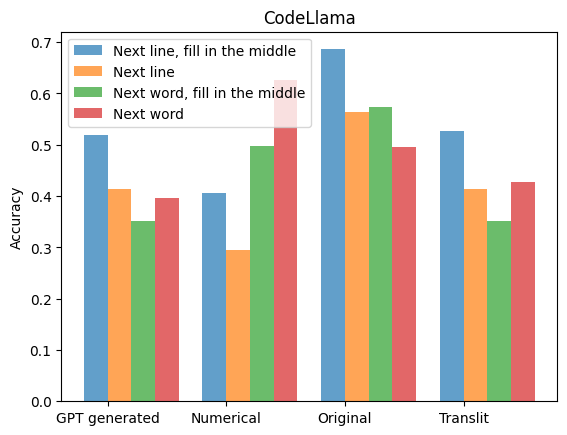

In [68]:
categories = ['Original', 'GPT generated', 'Numerical', 'Translit']

data1 = dict(code_lama_line_middle.groupby('name_type')['answer'].mean())
data2 = dict(code_lama_line.groupby('name_type')['answer'].mean())
data3 = dict(code_lama_next_word_middle.groupby('name_type')['answer'].mean())
data4 = dict(code_lama_next_word.groupby('name_type')['answer'].mean())

# Plotting
bar_width = 0.2
index = range(len(categories))

plt.bar(index, data1.values(), width=bar_width, label='Next line, fill in the middle', alpha=0.7, )
plt.bar([i + bar_width for i in index], data2.values(), width=bar_width, label='Next line', alpha=0.7)
plt.bar([i + bar_width*2 for i in index], data3.values(), width=bar_width, label='Next word, fill in the middle', alpha=0.7)
plt.bar([i + bar_width*3 for i in index], data4.values(), width=bar_width, label='Next word', alpha=0.7)

# Customize plot
plt.title('CodeLlama')
plt.ylabel('Accuracy')
plt.xticks([i + bar_width / 2 for i in index], data1.keys())
plt.legend()

# Show plot
plt.show()

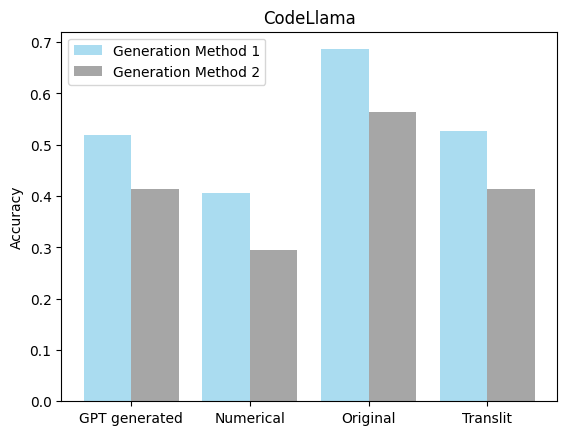

In [92]:
categories = ['Original', 'GPT generated', 'Numerical', 'Translit']

data1 = dict(code_lama_line_middle.groupby('name_type')['answer'].mean())
data2 = dict(code_lama_line.groupby('name_type')['answer'].mean())

# Plotting
bar_width = 0.4
index = range(len(categories))

plt.bar(index, data1.values(), width=bar_width, label='Generation Method 1', alpha=0.7, color='skyblue' )
plt.bar([i + bar_width for i in index], data2.values(), width=bar_width, label='Generation Method 2', alpha=0.7, color='grey')

# Customize plot
plt.title('CodeLlama')
plt.ylabel('Accuracy')
plt.xticks([i + bar_width / 2 for i in index], data1.keys())
plt.legend()

# Show plot
plt.show()

In [129]:
code_lama_full = pd.concat([code_lama_next_word,code_lama_line_middle, code_lama_line, code_lama_next_word_middle ])
code_lama_full.head(2)

,name_type,prompt,function_name,real,generated,answer,scores,ids,tokenised_name,line_ids,line_scores
0,Original,"def str(val):\n """"""Convert float to string,...",str,str(y),str(y)\n,True,"[16.53125, 20.796875, 20.03125, 20.15625, 22.5]","[851, 29898, 29891, 29897, 13]","[1, 851]","[851, 29898, 29891, 29897]","[16.53125, 20.796875, 20.03125, 20.15625]"
1,GPT generated,"def locale_aware_float_to_string(val):\n """"...",locale_aware_float_to_string,locale_aware_float_to_string(y),str(y)\n,False,"[16.765625, 21.890625, 20.625, 20.34375, 22.6875]","[851, 29898, 29891, 29897, 13]","[1, 15068, 29918, 28327, 29918, 7411, 29918, 5...","[851, 29898, 29891, 29897]","[16.765625, 21.890625, 20.625, 20.34375]"


In [131]:
correlation_coefficient, p_value = pearsonr(code_lama_full['tokenised_name'].apply(len), code_lama_full['answer'])
print(correlation_coefficient, p_value)

correlation_coefficient, p_value = pearsonr(code_lama_full['line_scores'].apply(np.mean), code_lama_full['answer'])
print(correlation_coefficient, p_value)

correlation_coefficient, p_value = pearsonr(code_lama_full['scores'].apply(np.mean), code_lama_full['answer'])
print(correlation_coefficient, p_value)



-0.04905009183323162 3.732596940939694e-10
0.444762940870037 0.0
0.41203929272201717 0.0


In [116]:
for i in range(len(code_lama_line)):
    if code_lama_line.iloc[i]['answer'] == True and code_lama_next_word.iloc[i]['answer'] == False:
        print(code_lama_next_word.iloc[i]['prompt'])
        print('Target func name: ',code_lama_next_word.iloc[i]['function_name'])
        print('\nNext word generated: ',code_lama_next_word.iloc[i]['generated'])
        print('\nLine generated: ',code_lama_line.iloc[i]['generated'])
        print('\n\n')

def str(val):
    """Convert float to string, taking the locale into account."""
    return _format("%.12g", val)

def colnum2name(n):
    "Translate a column number to name (e.g. 1->'A', etc.)."
    assert n > 0
    s = ""
    while n:
        n, m = divmod(n-1, 26)
        s = chr(m+ord('A')) + s
    return s
def cellname(x, y):
    "Translate a cell coordinate to a fancy cell name (e.g. (1, 1)->'A1')."
    assert x > 0 # Column 0 has an empty name, so can't use that
    return <FILL_ME>
Target func name:  colnum2name

Next word generated:  "%s%d" % (colnum2

Line generated:     return colnum2name(x) + str(y)



def erase_menu(stdscr, menu_y):
    "Clear the space where the menu resides"
    stdscr.move(menu_y, 0)
    stdscr.clrtoeol()
    stdscr.move(menu_y + 1, 0)
    stdscr.clrtoeol()
def display_menu(stdscr, menu_y):
    "Display the menu of possible keystroke commands"
    <FILL_ME>
Target func name:  erase_menu

Next word generated:  
    stdscr.move(menu_y

Line generated:    

# code_lama_next_word

In [134]:
from transformers import CodeLlamaTokenizer
tokenizer = CodeLlamaTokenizer.from_pretrained("codellama/CodeLlama-7b-hf")

In [136]:
tokenizer.decode(code_lama_next_word.iloc[0]['ids'])

'str(y)\n'

In [120]:
d = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1704697223.0315266.csv', index_col = 0)
print(d.iloc[8]['prompt'])
print(d.iloc[8]['generated'])

def str(val):
    """Convert float to string, taking the locale into account."""
    return _format("%.12g", val)

def colnum2name(n):
    "Translate a column number to name (e.g. 1->'A', etc.)."
    assert n > 0
    s = ""
    while n:
        n, m = divmod(n-1, 26)
        s = chr(m+ord('A')) + s
    return s
def cellname(x, y):
    "Translate a cell coordinate to a fancy cell name (e.g. (1, 1)->'A1')."
    assert x > 0 # Column 0 has an empty name, so can't use that
    return <FILL_ME>
"%s%d" % (colnum2


In [122]:
t = "fghjk"
"%s%d" % (t, 3)

'fghjk3'

In [105]:
code_lama_next_word.iloc[100]

name_type                                                  Original
prompt            def iter_importers(fullname=""):\n    """Yield...
function_name                                        iter_importers
real              iter_importers()\n    elif isinstance(path, st...
generated                               iter_importers()\n    else:
answer                                                         True
scores            [14.7109375, 19.765625, 22.375, 25.921875, 24....
ids               [4256, 29918, 326, 1971, 2153, 580, 13, 1678, ...
tokenised_name                    [1, 4256, 29918, 326, 1971, 2153]
line_ids                        [4256, 29918, 326, 1971, 2153, 580]
line_scores       [14.7109375, 19.765625, 22.375, 25.921875, 24....
Name: 100, dtype: object

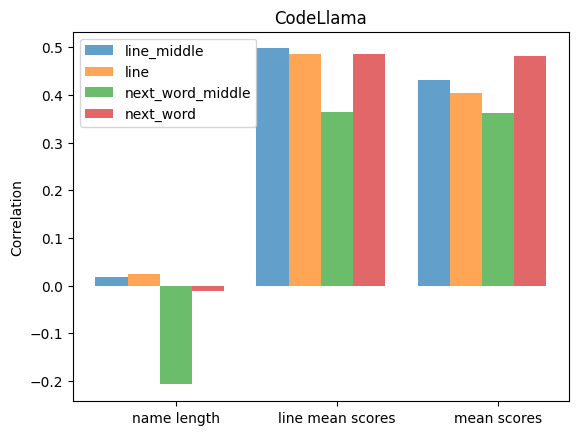

In [132]:
categories = ['Original', 'GPT generated', 'Numerical', 'Translit']
data = []
for i in [code_lama_line_middle, code_lama_line, code_lama_next_word_middle, code_lama_next_word]:
    d= []
    d.append(pearsonr(i['tokenised_name'].apply(len), i['answer'])[0])
    d.append(pearsonr(i['line_scores'].apply(np.mean), i['answer'])[0])
    d.append(pearsonr(i['scores'].apply(np.mean), i['answer'])[0])
    data.append(d)    

# Plotting
bar_width = 0.2
index = range(3)
datasets = ['line_middle', 'line', 'next_word_middle', 'next_word']
for i, d in enumerate(data):
    plt.bar([t + bar_width*i for t in index], d, width=bar_width, label=datasets[i], alpha=0.7, )
    
# Customize plot
plt.title('CodeLlama')
plt.ylabel('Correlation')
plt.xticks([i+bar_width*2 for i in index], ['name length', 'line mean scores', 'mean scores'])
plt.legend()

# Show plot
plt.show()

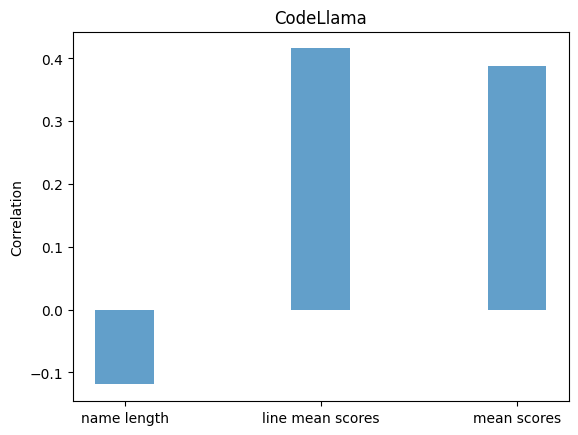

In [89]:
# Plotting
bar_width = 0.3
index = range(3)

plt.bar(index, [-0.11921010678033675, 0.41581485764959986, 0.38796368272457754], width=bar_width, alpha=0.7)

# Customize plot
plt.title('CodeLlama')
plt.ylabel('Correlation')
plt.xticks([i for i in index], ['name length', 'line mean scores', 'mean scores'])

# Show plot
plt.show()

In [46]:
code_lama_full.head(2)

,name_type,prompt,function_name,real,generated,answer,scores,ids,tokenised_name,line_ids,line_scores
0,Original,"def str(val):\n """"""Convert float to string,...",str,str(y),str(y)\n\ndef cellname2,True,"[16.53125, 20.796875, 20.03125, 20.15625, 22.5...","[851, 29898, 29891, 29897, 13, 13, 1753, 3038,...","[1, 851]","[851, 29898, 29891, 29897]","[16.53125, 20.796875, 20.03125, 20.15625]"
1,GPT generated,"def locale_aware_float_to_string(val):\n """"...",locale_aware_float_to_string,locale_aware_float_to_string(y),str(y)\n\ndef generate_cell,False,"[16.765625, 21.890625, 20.625, 20.34375, 22.68...","[851, 29898, 29891, 29897, 13, 13, 1753, 5706,...","[1, 15068, 29918, 28327, 29918, 7411, 29918, 5...","[851, 29898, 29891, 29897]","[16.765625, 21.890625, 20.625, 20.34375]"


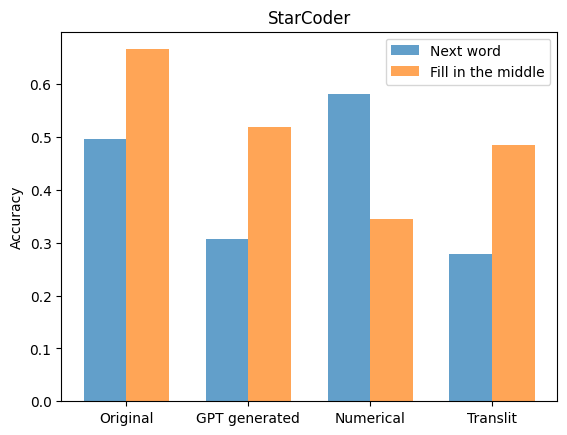

In [22]:
categories = ['Original', 'GPT generated', 'Numerical', 'Translit']
data1 = [0.4954954954954955, 0.3063063063063063, 0.581081081081081,  0.27837837837837837]
data2 = [0.6655879180151025, 0.5188781014023732, 0.3451995685005394, 0.4843581445523193]

 
# Plotting
bar_width = 0.35
index = range(len(categories))

plt.bar(index, data1, width=bar_width, label='Next word', alpha=0.7)
plt.bar([i + bar_width for i in index], data2, width=bar_width, label='Fill in the middle', alpha=0.7)

# Customize plot
plt.title('StarCoder')
plt.ylabel('Accuracy')
plt.xticks([i + bar_width / 2 for i in index], categories)
plt.legend()

# Show plot
plt.show()

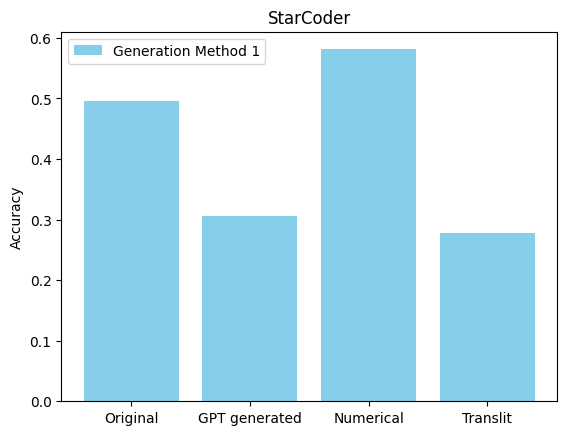

In [111]:
categories = ['Original', 'GPT generated', 'Numerical', 'Translit']
data1 = [0.4954954954954955, 0.3063063063063063, 0.581081081081081,  0.27837837837837837]
data2 = [0.6655879180151025, 0.5188781014023732, 0.3451995685005394, 0.4843581445523193]

 
# Plotting
bar_width = 0.3
index = range(len(categories))

plt.bar(index, data1, label='Generation Method 1',  color='skyblue')
plt.figsize=(10, 10)
# Customize plot
plt.title('StarCoder')
plt.ylabel('Accuracy')
plt.xticks(index, categories)
plt.legend()

# Show plot
plt.show()

In [11]:
!ls /home/sasha/effective-inference/clean_naming/logs

accurasies.log				generation_data_1702021803.0244296.csv
generation_data_1701993841.191603.csv	generation_data_1702022267.602238.csv
generation_data_1701993959.392148.csv	generation_data_1702022355.825838.csv
generation_data_1701994467.2871222.csv	generation_data_1702022423.392951.csv
generation_data_1701994654.7920356.csv	generation_data_1702224070.0987983.csv
generation_data_1701994927.1617575.csv	generation_data_1702224360.229674.csv
generation_data_1701995566.245585.csv	generation_data_1702225357.5887563.csv
generation_data_1701996220.5020876.csv	generation_data_1702230977.8872786.csv
generation_data_1701996943.1696708.csv	generation_data_1702428111.0287507.csv
generation_data_1701997078.3889523.csv	generation_data_1702428415.9782808.csv
generation_data_1702019914.2466471.csv	generation_data_1702428626.214518.csv
generation_data_1702019976.0920596.csv	generation_data_1702428785.191358.csv
generation_data_1702020272.4804516.csv	generation_data_1702428990.7710953.csv
generation_data_

In [12]:
# lama_next = pd.read_csv("/home/sasha/effective-inference/clean_naming/logs/next_word_generation.csv", index_col = 0)
# lama_next = pd.concat([lama_next, pd.read_csv('clean_naming/logs/generation_data_1702230977.8872786.csv', index_col = 0)])
# print(lama_next.shape)
# lama_next.to_csv("/home/sasha/effective-inference/clean_naming/logs/next_word_generation_full.csv")

In [13]:
lama_next = pd.read_csv("/home/sasha/effective-inference/clean_naming/logs/next_word_generation_full.csv", index_col = 0)
lama_line = pd.read_csv("/home/sasha/effective-inference/clean_naming/logs/line_generation.csv")
starcoder_next = pd.read_csv("/home/sasha/effective-inference/clean_naming/logs/generation_data_1702429222.2516284.csv")
starcoder_line = pd.read_csv("/home/sasha/effective-inference/clean_naming/logs/generation_data_1702455296.929821.csv")

In [14]:
lama_next['function_name'] = lama_next['real'].apply(lambda x: x.split("(")[0])
lama_next.head()

,name_type,prompt,real,generated,answer,function_name
0,Original,"def str(val):\n """"""Convert float to string,...",str(y),str(y)\n\ndef cellname2,True,str
1,GPT generated,"def locale_aware_float_to_string(val):\n """"...",locale_aware_float_to_string(y),str(y)\n\ndef generate_cell,False,locale_aware_float_to_string
2,Numerical,"def 0(val):\n """"""Convert float to string, t...",0(y),0(y)\ndef 3(x,True,0
3,Original,"def str(val):\n """"""Convert float to string,...",colnum2name(x) + str(y),"""%s%d"" % (colnum2",False,colnum2name
4,GPT generated,"def locale_aware_float_to_string(val):\n """"...",convert_column_number_to_name(x) + locale_awar...,convert_column_number_to_name(,True,convert_column_number_to_name


In [29]:
from scipy.stats import entropy
from collections import Counter
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns


def calculate_entropy(text):
    # Подсчет частот символов
    frequencies = Counter(text)
    total_characters = len(text)
    probabilities = [frequency / total_characters for frequency in frequencies.values()]
    entropy_value = entropy(probabilities, base=2)

    return entropy_value
    
corr = {}
df_dict = {'lama_next':lama_next, "lama_line":lama_line, "starcoder_next":starcoder_next, "starcoder_line":starcoder_line}
param = 'function_name'
for name, data in df_dict.items():

    corr[name] = {}
    
    entropies = data[param].apply(str).apply(calculate_entropy)
    # Calculate the Pearson correlation coefficient
    correlation_coefficient, p_value = pearsonr(entropies, data['answer'])
        
    print(f"{name} :\ncorrelation_coefficient: {correlation_coefficient}, p_value: {p_value}")
    corr[name] = correlation_coefficient

lama_next :
correlation_coefficient: -0.2307725149334873, p_value: 9.408429056759468e-55
lama_line :
correlation_coefficient: -0.18745978321151605, p_value: 2.0667021644301356e-23
starcoder_next :
correlation_coefficient: -0.18738587455975036, p_value: 2.268434210335392e-36
starcoder_line :
correlation_coefficient: 0.18145184158375505, p_value: 8.188090310495378e-29


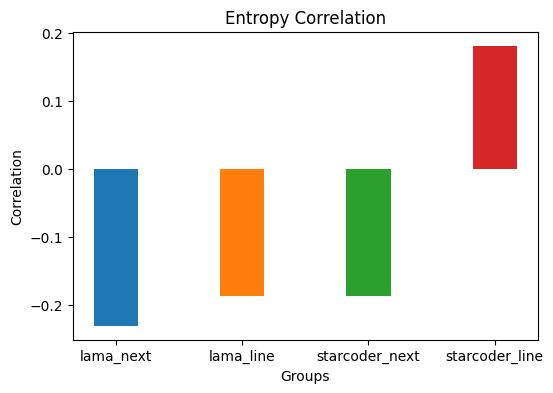

In [30]:
df_names = list(corr.keys())
correlations = np.array(list(corr.values()))  # Transpose the array for proper grouping

# Set up positions for the bars
positions = np.arange(1,4)
bar_width = 0.35  # Adjust as needed

# Create grouped bar plot
fig, ax = plt.subplots(1,1,figsize=(6, 4))

for i, name in enumerate(df_names):
    ax.bar(df_names[i], correlations[i], bar_width, label=name)

# Add labels and legend
ax.set_xlabel('Groups')
ax.set_ylabel('Correlation')
ax.set_title('Entropy Correlation')

# Show the plot
plt.show()

In [1]:
from transformers import LlamaForCausalLM, CodeLlamaTokenizer
tokenizer = CodeLlamaTokenizer.from_pretrained("codellama/CodeLlama-7b-hf")
model = LlamaForCausalLM.from_pretrained("codellama/CodeLlama-7b-hf", load_in_8bit=True,
    device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [31]:
import torch
prompt = ""
input_ids = tokenizer.encode(prompt, return_tensors="pt")
output = model.generate(input_ids, return_dict_in_generate=True, output_scores=True)
loss, logits = output[:2]
logits_first_token = logits[0]
probabilities = torch.nn.functional.softmax(logits_first_token, dim=-1)

def get_prob(text):
    target_token_id = tokenizer.encode(text)[-1]
    target_probability = probabilities[0, target_token_id].item()
    return target_probability  
corr = {}
df_dict = {'lama_next':lama_next, "lama_line":lama_line, "starcoder_next":starcoder_next, "starcoder_line":starcoder_line}
param = 'function_name'
for name, data in df_dict.items():

    corr[name] = {}
    
    entropies = data[param].apply(str).apply(get_prob)
    # Calculate the Pearson correlation coefficient
    correlation_coefficient, p_value = pearsonr(entropies, data['answer'])
        
    print(f"{name} :\ncorrelation_coefficient: {correlation_coefficient}, p_value: {p_value}")
    corr[name] = correlation_coefficient


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


lama_next :
correlation_coefficient: -0.01279902245545556, p_value: 0.3938610751788883
lama_line :
correlation_coefficient: 0.03880801937015463, p_value: 0.040717133257158165
starcoder_next :
correlation_coefficient: -0.015074165053973443, p_value: 0.3152745249510064
starcoder_line :
correlation_coefficient: 0.04537618294151904, p_value: 0.005716764252201444


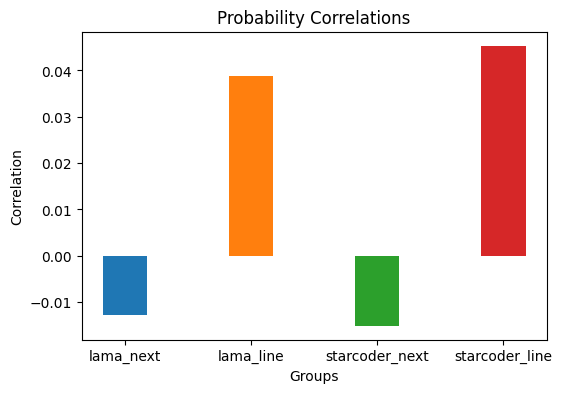

In [32]:
df_names = list(corr.keys())
correlations = np.array(list(corr.values()))  # Transpose the array for proper grouping

# Set up positions for the bars
positions = np.arange(1,4)
bar_width = 0.35  # Adjust as needed

# Create grouped bar plot
fig, ax = plt.subplots(1,1,figsize=(6, 4))

for i, name in enumerate(df_names):
    ax.bar(df_names[i], correlations[i], bar_width, label=name)

# Add labels and legend
ax.set_xlabel('Groups')
ax.set_ylabel('Correlation')
ax.set_title('Probability Correlations')

# Show the plot
plt.show()

In [365]:
c

In [368]:
correlation_coefficient, p_value

(-0.18745978321151605, 2.0667021644301356e-23)

In [367]:
p_value

2.0667021644301356e-23